In [1]:
import numpy as np
# %matplotlib notebook
from matplotlib import pyplot as plt
from scipy import stats
import sys
import os
import healpy as hp

DCOLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Functions from PCLCovariance project
# https://github.com/damonge/PCLCovariance/blob/master/notebooks/common.py
FIGSIZE = (4, 3)
def plot_chi2(chi2s, labels, lmax, bins=60, foutput=None):
    "Copied from https://github.com/damonge/PCLCovariance/blob/master/notebooks/common.py"
    f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    _, x, _ = ax.hist(chi2s, bins=bins, histtype='step', density=True, label=labels)

    ax.plot(x[:-1], stats.chi2.pdf(x[:-1], lmax), ls='--', label=r'$\chi^2$ pdf')

    ax.set_xlabel(r'$\chi^2$')
    ax.set_ylabel('pdf')

    ax.legend(loc=0)
    plt.tight_layout()
    if foutput is not None:
        fname = foutput + '_chi2'
        plt.savefig(fname, dpi=DPI)
    plt.show()
    plt.close()
    
def correlation_matrix(covariance):
    c = np.diag(covariance)
    return covariance / np.sqrt(c * c[:, None])

def get_correlation_from_covariance(array_of_covs):
    array_of_corrs = []
    for Cov in array_of_covs:
        array_of_corrs.append(correlation_matrix(Cov))

    return array_of_corrs

def plot_correlation_difference(lbins, CovSims, CovTh, labelTh='Th', foutput=None):
    CorrSims, CorrTh = get_correlation_from_covariance([CovSims, CovTh])

    f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    diff = CorrSims - CorrTh
    lim = np.abs(diff).max()
    plt.imshow(diff, vmin=-lim, vmax=lim)
    c = plt.colorbar()
    c.set_label('CorrSims - Corr{}'.format(labelTh))
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$\ell$')

    lbins = lbins.astype(int)
    ticks = np.linspace(0, len(lbins)-1, 7, dtype=int)

    plt.xticks(ticks, lbins[ticks])
    plt.yticks(ticks, lbins[ticks])

    plt.tight_layout()
    if foutput is not None:
        fname = foutput + '_correlation_difference'
        plt.savefig(fname, dpi=DPI)

    plt.show()
    plt.close()

    return CorrSims, CorrTh

In [3]:
lbpw4096 = np.loadtxt('/mnt/extraspace/gravityls_3/S8z/Cls/all_together/l_bpw.txt')
lbpw512 = np.loadtxt('/mnt/extraspace/gravityls_3/S8z/Cls/all_together_im3shape_512_new/l_bpw.txt')

# Covariances gc0gc0

In [4]:
# cls = np.zeros((100, lbpw4096.size))
# for i in range(100):
#     cls[i] = np.load(simsdir + 'run_gc0gc0_cl_%04d.npz' % (i+1))['cltt']
# np.savez(simsdir + 'run_gc0gc0_clsims_0001-0100.npz', cl00=cls.reshape(100, 1, -1), l=lbpw4096)
# np.savez(simsdir + 'run_gc0gc0_covSims_0001-0100.npz', np.cov(cls.T))

## 2048

In [10]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_new_ws/'
# simsdir = './sims/'

# gc0gc0 = np.load(simsdir + 'run_gc0gc0_clsims_0001-0100.npz')
# # gc0gc02 = np.load(simsdir + 'run_gc0gc0_clsims_0101-1000.npz')
# gc0gc0total = np.concatenate([gc0gc0['cl00'], gc0gc02['cl00']], axis=0)
# np.savez(simsdir + 'run_gc0gc0_clsims_0001-1000.npz', cl00=gc0gc0total, l=gc0gc0['l'])
# cls_sims = gc0gc0['cl00'][:, 0, :]
# CovSims = np.cov(cls_sims.T)
# np.savez(simsdir + 'run_gc0gc0_covSims_0001-1000.npz', CovSims)

CovSims = np.load(simsdir + 'run_gc0gc0_covSims_0001-1000.npz')['arr_0']
CovTh = np.load(simsdir + 'run_gc0gc0_covTh.npz')['arr_0']
CovThLklFull = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/all_together/new_fiducial_cov/cov_DESgc0_DESgc0_DESgc0_DESgc0.npz')['arr_0']
CovThLkl = CovThLklFull[:CovTh.shape[0], :CovTh.shape[0]]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThLkl = np.linalg.inv(CovThLkl)

gc0gc0 = np.load(simsdir + 'run_gc0gc0_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]
nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThLkl = np.ones(nsims) * (-1)


for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThLkl[i] = (delta).dot(iCovThLkl).dot(delta)

### $\chi^2$

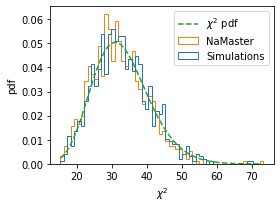

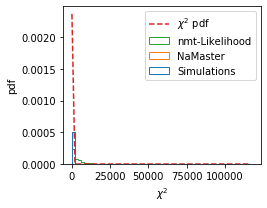

In [11]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], ells.size)
plot_chi2([chi2_sims, chi2_Th, chi2_ThLkl], ['Simulations', 'NaMaster', 'nmt-Likelihood'], ells.size)

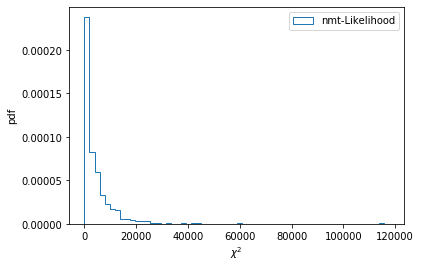

In [12]:
plt.hist(chi2_ThLkl, bins=60, density=True, label='nmt-Likelihood', histtype='step')
plt.xlabel(r'$\chi^2$')
plt.ylabel('pdf')
plt.legend(loc=0)
plt.show()
plt.close()

### Diff correlation matrix

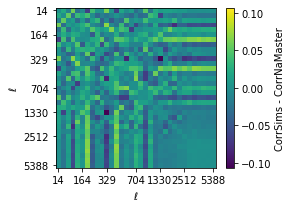

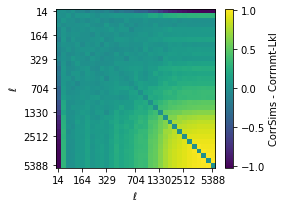

In [13]:
plot_correlation_difference(lbpw2048, CovSims, CovTh, labelTh='NaMaster');
plot_correlation_difference(lbpw2048, CovSims, CovThLkl, labelTh='nmt-Lkl');

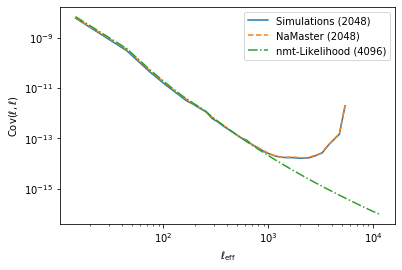

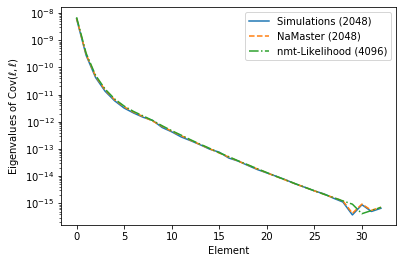

In [20]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(lbpw2048, np.diag(CovSims), label='Simulations (2048)')
plt.plot(lbpw2048, np.diag(CovTh), ls='--', label='NaMaster (2048)')
plt.plot(lbpw4096, np.diag(CovThLklFull), ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (2048)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (2048)')
plt.plot(np.linalg.eig(CovThLkl)[0], ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

In [17]:
# Check if eigenvectors are different
_, vSims = np.linalg.eigh(CovSims)
_, vTh = np.linalg.eigh(CovTh)
_, vThLkl = np.linalg.eigh(CovThLkl)

print(vSims[0].dot(vTh[0]))
print(vSims[0].dot(vThLkl[0]))
print(vSims[0].dot(vTh[1]))
print(vSims[0].dot(vThLkl[1]))

0.9999559805052736
0.9997024643997597
-0.008218724130145086
-0.00745830813193013


### $C_\ell$

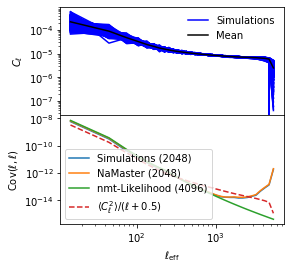

In [39]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(lbpw2048, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(lbpw2048, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(lbpw2048, np.diag(CovSims), label='Simulations (2048)')
ax[1].plot(lbpw2048, np.diag(CovTh), label='NaMaster (2048)')
ax[1].plot(lbpw2048, np.diag(CovThLkl), label='nmt-Likelihood (4096)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(lbpw2048, cls_sims_mean**2/(lbpw2048 +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

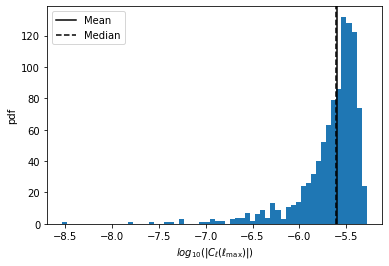

In [69]:
h = plt.hist(np.log10(np.abs(cls_sims[:, -1])), bins=60)
plt.axvline(np.log10(cls_sims_mean[-1]), c='k', label='Mean')
plt.axvline(h[1][np.argmin(np.abs(np.cumsum(h[0]) - 500))], c='k', ls='--', label='Median')
plt.xlabel(r'$log_{10}(|C_\ell(\ell_{\rm max})|)$')
plt.ylabel('pdf')
plt.legend(loc=0)
plt.show()

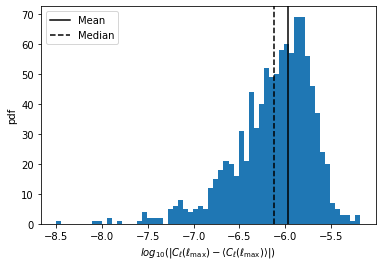

In [70]:
h = plt.hist(np.log10(np.abs(cls_sims[:, -1] - cls_sims_mean[-1])), bins=60)
plt.axvline(np.log10(np.mean(np.abs(cls_sims[:, -1] - cls_sims_mean[-1]))), c='k', label='Mean')
plt.axvline(h[1][np.argmin(np.abs(np.cumsum(h[0]) - 500))], c='k', ls='--', label='Median')
plt.xlabel(r'$log_{10}(|C_\ell(\ell_{\rm max}) - \langle C_\ell(\ell_{\rm max}) \rangle|)$')
plt.ylabel('pdf')
plt.legend(loc=0)
plt.show()

### Noise

In [12]:
obsdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together'
desgc_nls_arr4096 = np.load(os.path.join(obsdir, 'des_w_cl_shot_noise_ns4096.npz'))['cls']
obsdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_2048/'
desgc_nls_arr2048 = np.load(os.path.join(obsdir, 'des_w_cl_shot_noise_ns2048.npz'))['cls']

# cls2048 = np.loadtxt('./sims/run_gc0gc0_cl_th.txt')
# cls4096 = np.loadtxt()

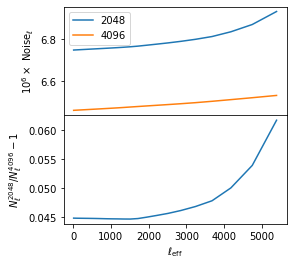

In [13]:
f, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True, gridspec_kw={'hspace':0})
ax[0].plot(lbpw2048, 1e6 * desgc_nls_arr2048[0], label='2048')
ax[0].plot(lbpw2048, 1e6 * desgc_nls_arr4096[0, :lbpw2048.size], label='4096')
ax[1].plot(lbpw2048, desgc_nls_arr2048[0] / desgc_nls_arr4096[0, :lbpw2048.size] -1)

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[0].set_ylabel(r'$10^6 \times$ Noise$_\ell$')
ax[1].set_ylabel(r'$N_\ell^{2048} / N_\ell^{4096} - 1$')

ax[0].legend(loc=0)
plt.show()
plt.close()

## 4096

In [5]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_new_ws_ns4096/'

# ells = lbpw4096
# cls_sims = np.zeros((55, ells.size))
# for i in range(55):
#     cls_sims[i] = np.load(simsdir + 'run_gc0gc0_cl_%04d.npz' % (i+1))['cltt']
# CovSims = np.cov(cls_sims.T)

CovSims = np.load(simsdir + 'run_gc0gc0_covSims_0001-0100.npz')['arr_0']
CovTh = np.load(simsdir + 'run_gc0gc0_covTh.npz')['arr_0']
CovThLklFull = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/all_together/new_fiducial_cov/cov_DESgc0_DESgc0_DESgc0_DESgc0.npz')['arr_0']
CovThLkl = CovThLklFull[:CovTh.shape[0], :CovTh.shape[0]]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThLkl = np.linalg.inv(CovThLkl)

gc0gc0 = np.load(simsdir + 'run_gc0gc0_clsims_0001-0100.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThLkl = np.ones(nsims) * (-1)


for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThLkl[i] = (delta).dot(iCovThLkl).dot(delta)

### $\chi^2$

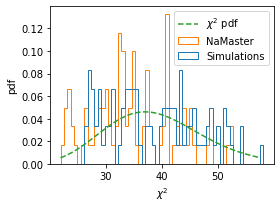

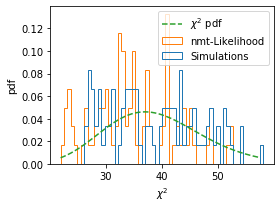

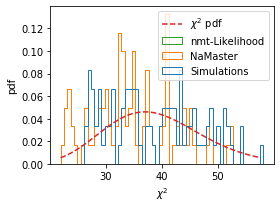

In [6]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], ells.size)
plot_chi2([chi2_sims, chi2_ThLkl], ['Simulations', 'nmt-Likelihood'], ells.size)
plot_chi2([chi2_sims, chi2_Th, chi2_ThLkl], ['Simulations', 'NaMaster', 'nmt-Likelihood'], ells.size)

### Diff correlation matrix

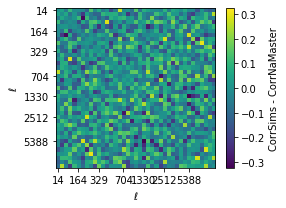

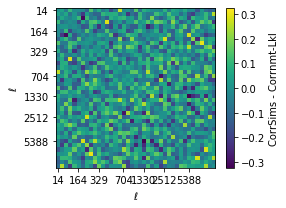

In [7]:
plot_correlation_difference(lbpw2048, CovSims, CovTh, labelTh='NaMaster');
plot_correlation_difference(lbpw2048, CovSims, CovThLkl, labelTh='nmt-Lkl');

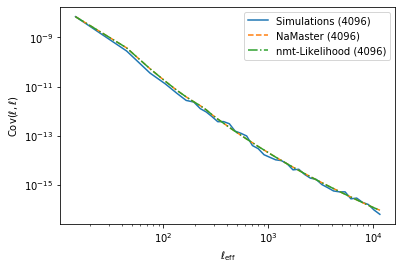

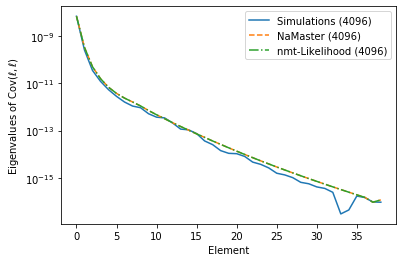

In [22]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), label='Simulations (4096)')
plt.plot(ells, np.diag(CovTh), ls='--', label='NaMaster (4096)')
plt.plot(lbpw4096, np.diag(CovThLklFull), ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (4096)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (4096)')
plt.plot(np.linalg.eig(CovThLkl)[0], ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### $C_\ell$

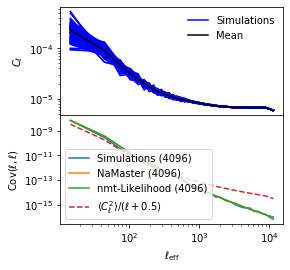

In [24]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), label='Simulations (4096)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (4096)')
ax[1].plot(ells, np.diag(CovThLkl), label='nmt-Likelihood (4096)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

# Covariances gc3wl1

## 4096

In [4]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_gc3wl1/'
fiddir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/new_fiducial_cov/'

# ells = lbpw4096
# cls_sims = np.zeros((55, ells.size))
# for i in range(55):
#     cls_sims[i] = np.load(simsdir + 'run_gc0gc0_cl_%04d.npz' % (i+1))['cltt']

gc0gc0 = np.load(simsdir + 'run_gc3wl1_clsims_0001-0100.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cls'][:, 0, :]
CovSims = np.cov(cls_sims.T)

# CovSims = np.load(simsdir + 'run_gc3wl1_covSims_0001-0100.npz')['arr_0']
CovTh = np.load(simsdir + 'run_gc3wl1_covTh.npz')['arr_0'].reshape(lbpw4096.size, 2, lbpw4096.size, 2)[:, 0, :, 0]
CovThLklFull = np.load(fiddir + 'cov_DESgc3_DESwl1_DESgc3_DESwl1.npz')['arr_0']
CovThLkl = CovThLklFull[:lbpw4096.size, :lbpw4096.size]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThLkl = np.linalg.inv(CovThLkl)

# gc0gc0 = np.load(simsdir + 'run_gc3wl1_clsims_0001-0100.npz')
# ells = gc0gc0['l']
# cls_sims = gc0gc0['cls'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThLkl = np.ones(nsims) * (-1)


for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThLkl[i] = (delta).dot(iCovThLkl).dot(delta)

In [6]:
cls_fid_reconst = np.loadtxt(simsdir + 'run_gc3wl1_cl_th.txt', usecols=1)
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_fid = cls_fid_data['cls']

### $\chi^2$

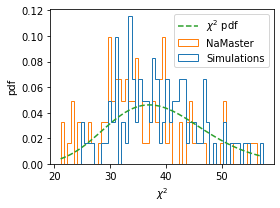

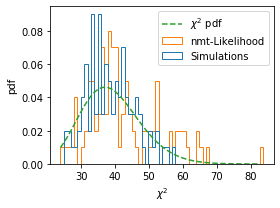

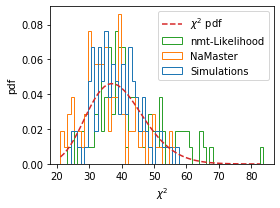

In [7]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], ells.size)
plot_chi2([chi2_sims, chi2_ThLkl], ['Simulations', 'nmt-Likelihood'], ells.size)
plot_chi2([chi2_sims, chi2_Th, chi2_ThLkl], ['Simulations', 'NaMaster', 'nmt-Likelihood'], ells.size)

### Diff correlation matrix

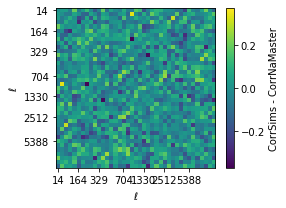

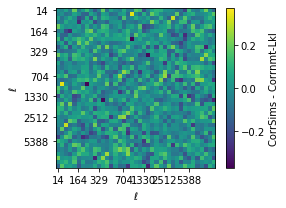

In [8]:
plot_correlation_difference(lbpw2048, CovSims, CovTh, labelTh='NaMaster');
plot_correlation_difference(lbpw2048, CovSims, CovThLkl, labelTh='nmt-Lkl');

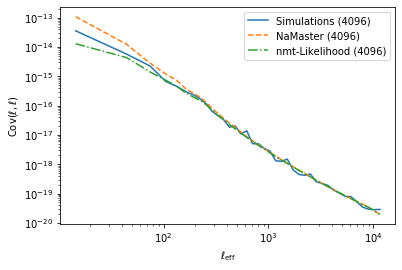

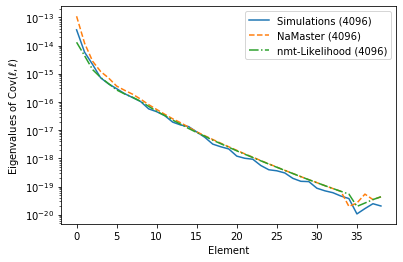

In [9]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), label='Simulations (4096)')
plt.plot(ells, np.diag(CovTh), ls='--', label='NaMaster (4096)')
plt.plot(lbpw4096, np.diag(CovThLklFull), ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (4096)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (4096)')
plt.plot(np.linalg.eig(CovThLkl)[0], ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### $C_\ell$

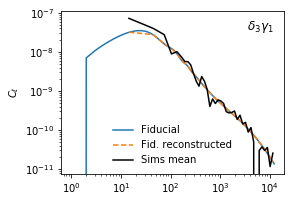

In [10]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_fid, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta_3 \gamma_1$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

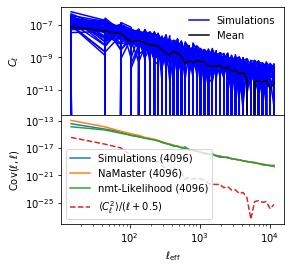

In [11]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), label='Simulations (4096)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (4096)')
ax[1].plot(ells, np.diag(CovThLkl), label='nmt-Likelihood (4096)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

# Covariances wl1wl1

## 4096

In [18]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_wl1wl1/'
obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/'
covdir = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together/new_fiducial_cov/'

# ells = lbpw4096
# cls_sims = np.zeros((55, ells.size))
# for i in range(55):
#     cls_sims[i] = np.load(simsdir + 'run_gc0gc0_cl_%04d.npz' % (i+1))['cltt']

gc0gc0 = np.load(simsdir + 'run_wl1wl1_clsims_0001-0100.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cls'][:, 0, :]
CovSims = np.cov(cls_sims.T)

# CovSims = np.load(simsdir + 'run_gc3wl1_covSims_0001-0100.npz')['arr_0']
CovTh = np.load(simsdir + 'run_wl1wl1_covTh.npz')['arr_0'].reshape(lbpw4096.size, 4, lbpw4096.size, 4)[:, 0, :, 0]
CovThLklFull = np.load(covdir + 'cov_DESwl1_DESwl1_DESwl1_DESwl1.npz')['arr_0']
CovThLkl = CovThLklFull[:lbpw4096.size, :lbpw4096.size]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThLkl = np.linalg.inv(CovThLkl)

# gc0gc0 = np.load(simsdir + 'run_gc3wl1_clsims_0001-0100.npz')
# ells = gc0gc0['l']
# cls_sims = gc0gc0['cls'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThLkl = np.ones(nsims) * (-1)


for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThLkl[i] = (delta).dot(iCovThLkl).dot(delta)

In [21]:
from scipy.interpolate import interp1d
cls_fid_reconst = np.loadtxt(simsdir + 'run_wl1wl1_cl_th.txt', usecols=1)
fname = os.path.join(obs_path, 'des_sh_metacal_rot0-10_noise_ns4096.npz')
nls = np.load(fname)
nlee = nls['cls'][1, 0, 0]
nlee = interp1d(nls['l'],  nlee, bounds_error=False,
                fill_value=(nlee[0], nlee[-1]))(lbpw4096)

cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESwl1_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_fid = cls_fid_data['cls']

### $\chi^2$

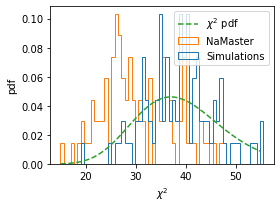

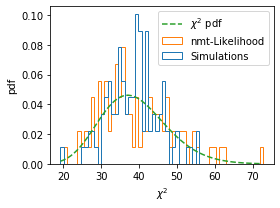

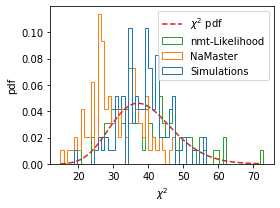

In [10]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], ells.size)
plot_chi2([chi2_sims, chi2_ThLkl], ['Simulations', 'nmt-Likelihood'], ells.size)
plot_chi2([chi2_sims, chi2_Th, chi2_ThLkl], ['Simulations', 'NaMaster', 'nmt-Likelihood'], ells.size)

### Diff correlation matrix

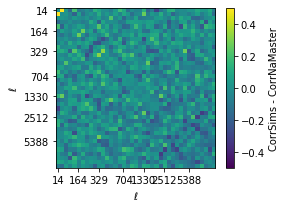

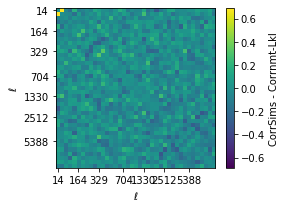

In [11]:
plot_correlation_difference(lbpw2048, CovSims, CovTh, labelTh='NaMaster');
plot_correlation_difference(lbpw2048, CovSims, CovThLkl, labelTh='nmt-Lkl');

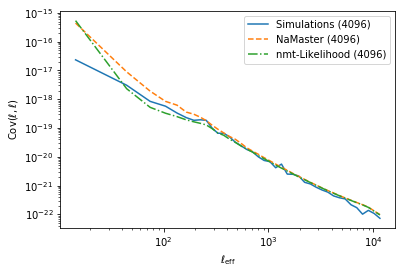

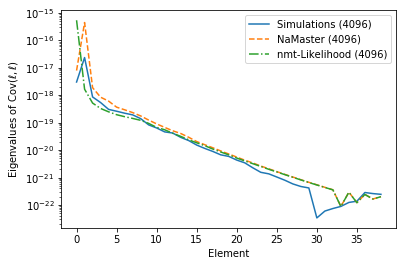

In [12]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), label='Simulations (4096)')
plt.plot(ells, np.diag(CovTh), ls='--', label='NaMaster (4096)')
plt.plot(lbpw4096, np.diag(CovThLklFull), ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (4096)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (4096)')
plt.plot(np.linalg.eig(CovThLkl)[0], ls='-.', label='nmt-Likelihood (4096)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### $C_\ell$

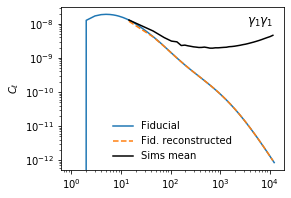

In [28]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_fid, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_1 \gamma_1$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

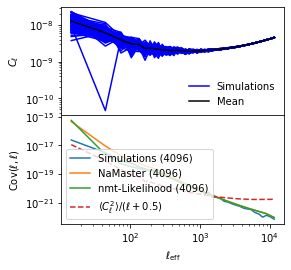

In [14]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), label='Simulations (4096)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (4096)')
ax[1].plot(ells, np.diag(CovThLkl), label='nmt-Likelihood (4096)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

# Covariances for flat $C_\ell$

In [4]:
ells_fid = np.arange(lbpw512[-1])
cls_fid = np.ones(ells_fid.size)

## gc-gc

In [5]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_debug_flat_cls/'
prefix = simsdir + 'run_debug_flat_cls_'

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

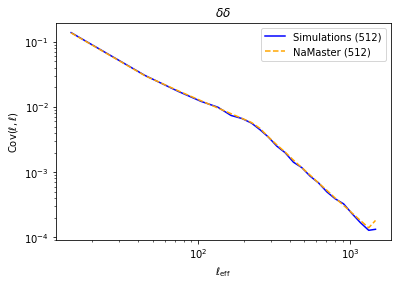

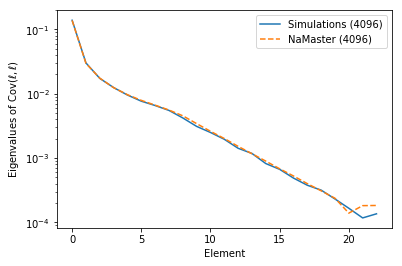

In [6]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \delta$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (4096)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (4096)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

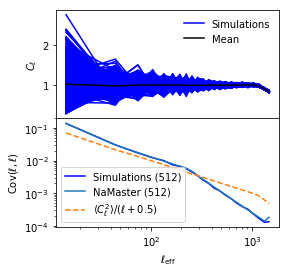

In [7]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

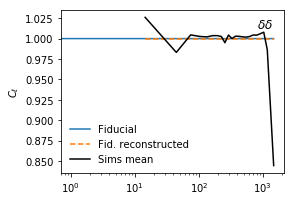

In [8]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_fid, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \delta$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## gc-wl

In [9]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_debug_flat_cls/'
prefix = simsdir + 'run_debug_flat_cls_'

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=2)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

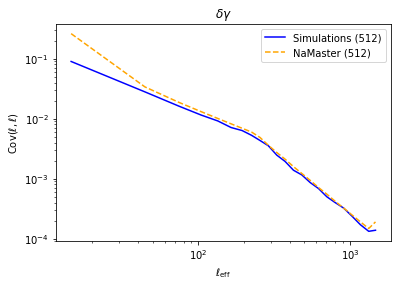

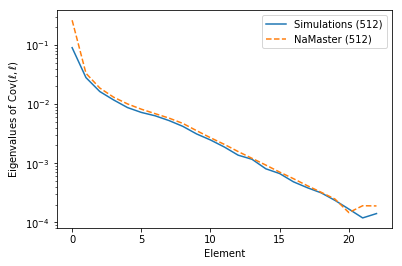

In [10]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

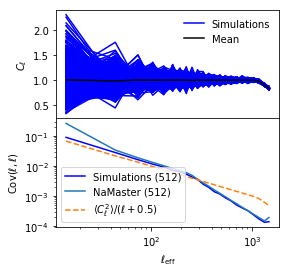

In [11]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

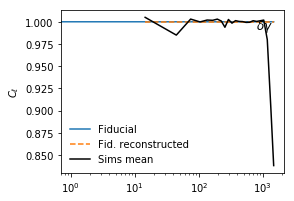

In [12]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_fid, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## wl-wl

In [13]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_debug_flat_cls/'
prefix = simsdir + 'run_debug_flat_cls_'

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

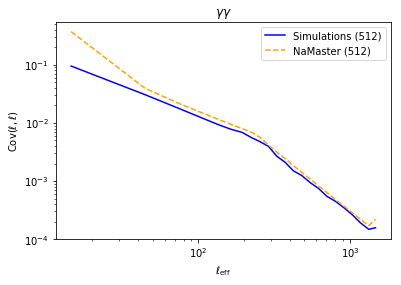

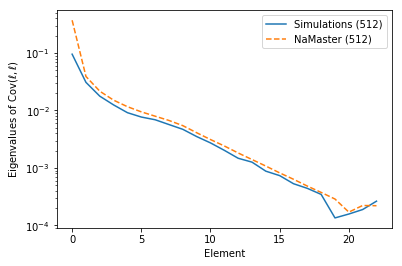

In [14]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

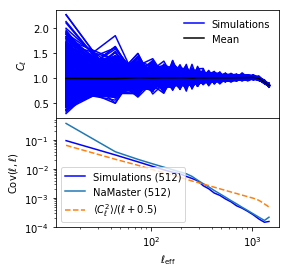

In [15]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

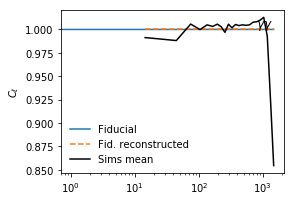

In [16]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_fid, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## gcgc - gcwl - wlwl

In [17]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_debug_flat_cls/'
prefix = simsdir + 'run_debug_flat_cls_'

ells = lbpw512
nells = lbpw512.size
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
nsims = gc0gc0['cl00'].shape[0]
ells = gc0gc0['l']
cls_sims = np.zeros((nsims, nells * 3))
cls_sims[:, :nells] = gc0gc0['cl00'][:, 0, :]
cls_sims[:, nells : 2*nells] = gc0gc0['cl02'][:, 0, :]
cls_sims[:, 2*nells :] = gc0gc0['cl22'][:, 0, :]

cls_sims_mean = np.mean(cls_sims, axis=0)

CovSims = np.cov(cls_sims.T)

CovTh = np.zeros((nells * 3, nells * 3))
Cload = np.load(prefix + '_covTh.npz')
# TT-TT
nelems1 = 1
nelems2 = 1
C = Cload['cw00_00'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, :nells] = C
# TT-TE
nelems1 = 1
nelems2 = 2
C = Cload['cw00_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, nells:2*nells] = C
CovTh[nells:2*nells, :nells] = C.T
# TT-EE
nelems1 = 1
nelems2 = 4
C = Cload['cw00_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, :nells] = C.T
## TE-TE
nelems1 = 2
nelems2 = 2
C = Cload['cw02_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, nells:2*nells] = C
## TE-EE
nelems1 = 2
nelems2 = 4
C = Cload['cw02_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, nells:2*nells] = C.T
## EE-EE
nelems1 = 4
nelems2 = 4
C = Cload['cw22_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[2*nells:3*nells, 2*nells:3*nells] = C

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

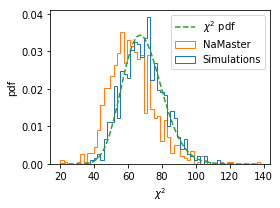

In [18]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], 3*nells)

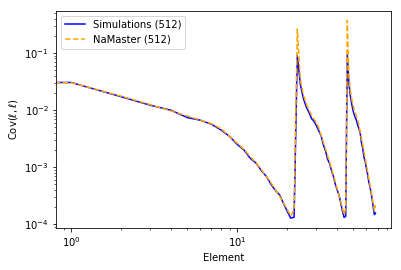

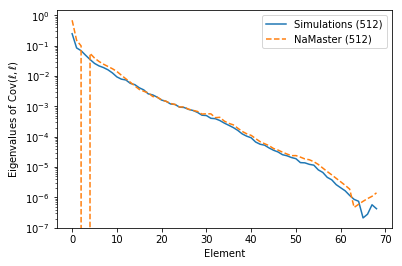

In [19]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

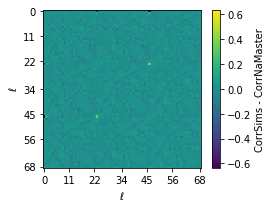

In [20]:
plot_correlation_difference(np.arange(3*nells), CovSims, CovTh, labelTh='NaMaster');

# gc3 - wl1 512 all with shear noise from rotation

In [7]:
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_gc3wl1 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESgc3.npz')
cls_gc3gc3 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESwl1_DESwl1.npz')
cls_wl1wl1 = cls_fid_data['cls']

obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_im3shape_512_newbin/'
nside = 512
wltype = 'im3shape'
l = ells_fid
from scipy.interpolate import interp1d
# gc3
fname = os.path.join(obs_path, 'des_w_cl_shot_noise_ns{}.npz'.format(nside))
nls = np.load(fname)
nltt = nls['cls'][3]
nltt_int = interp1d(nls['l'],  nltt, bounds_error=False,
                fill_value=(nltt[0], nltt[-1]))(l)
# wl1
fname = os.path.join(obs_path, 'des_sh_{}_rot0-10_noise_ns{}.npz'.format(wltype, nside))
nls = np.load(fname)
nlee = nls['cls'][1, 0, 0]
nlbb = nls['cls'][1, 1, 1]
nlee_int = interp1d(nls['l'],  nlee, bounds_error=False,
                fill_value=(nlee[0], nlee[-1]))(l)
nlbb_int = interp1d(nls['l'],  nlbb, bounds_error=False,
                fill_value=(nlbb[0], nlbb[-1]))(l)

## gc-gc

In [8]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_gc3_wl1_all/'
prefix = simsdir + 'run_gc3_wl1_all'

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

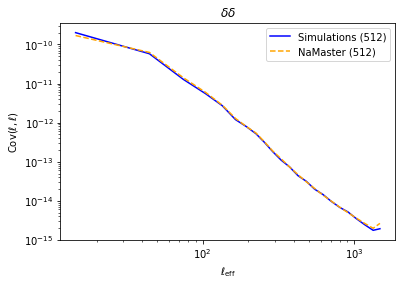

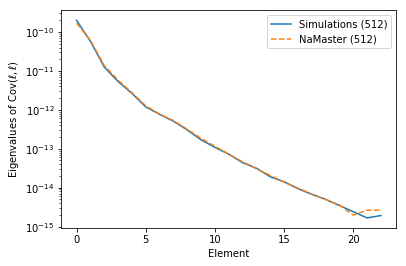

In [9]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \delta$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

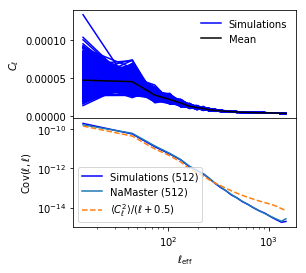

In [10]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

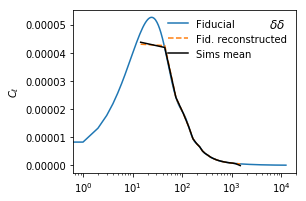

In [11]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_gc3gc3, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean - nltt, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \delta$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## gc-wl

In [12]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_gc3_wl1_all/'
prefix = simsdir + 'run_gc3_wl1_all'
ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=2)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

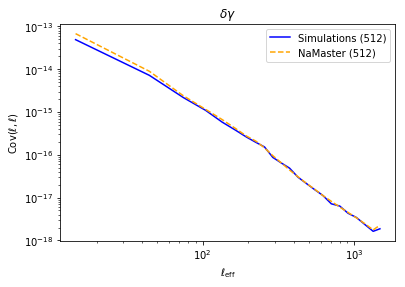

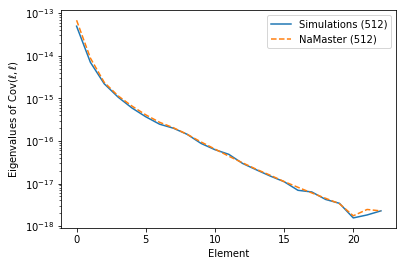

In [13]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

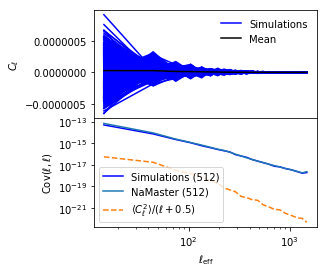

In [14]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

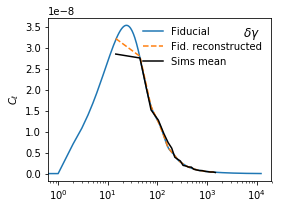

In [15]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_gc3wl1, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## wl-wl

In [16]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_gc3_wl1_all/'
prefix = simsdir + 'run_gc3_wl1_all'

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

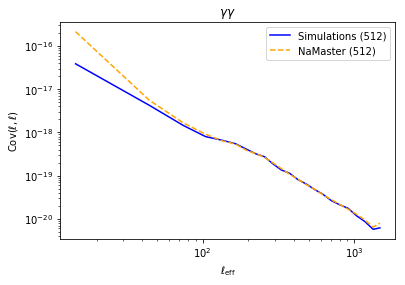

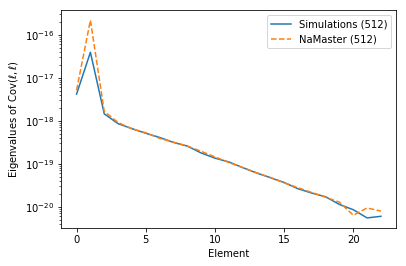

In [17]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

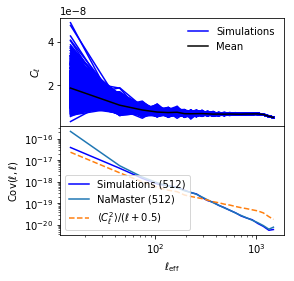

In [18]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

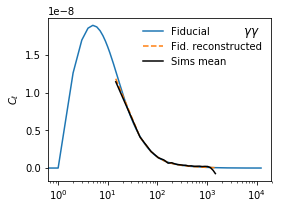

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean - nlee, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## gcgc - gcwl - wlwl

In [21]:
# Load Cls, covariances, compute inverses and chi2

simsdir = './sims_gc3_wl1_all/'
prefix = simsdir + 'run_gc3_wl1_all'

ells = lbpw512
nells = lbpw512.size
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
nsims = gc0gc0['cl00'].shape[0]
ells = gc0gc0['l']
cls_sims = np.zeros((nsims, nells * 3))
cls_sims[:, :nells] = gc0gc0['cl00'][:, 0, :]
cls_sims[:, nells : 2*nells] = gc0gc0['cl02'][:, 0, :]
cls_sims[:, 2*nells :] = gc0gc0['cl22'][:, 0, :]

cls_sims_mean = np.mean(cls_sims, axis=0)

CovSims = np.cov(cls_sims.T)

CovTh = np.zeros((nells * 3, nells * 3))
Cload = np.load(prefix + '_covTh.npz')
# TT-TT
nelems1 = 1
nelems2 = 1
C = Cload['cw00_00'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, :nells] = C
# TT-TE
nelems1 = 1
nelems2 = 2
C = Cload['cw00_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, nells:2*nells] = C
CovTh[nells:2*nells, :nells] = C.T
# TT-EE
nelems1 = 1
nelems2 = 4
C = Cload['cw00_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, :nells] = C.T
## TE-TE
nelems1 = 2
nelems2 = 2
C = Cload['cw02_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, nells:2*nells] = C
## TE-EE
nelems1 = 2
nelems2 = 4
C = Cload['cw02_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, nells:2*nells] = C.T
## EE-EE
nelems1 = 4
nelems2 = 4
C = Cload['cw22_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[2*nells:3*nells, 2*nells:3*nells] = C

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)

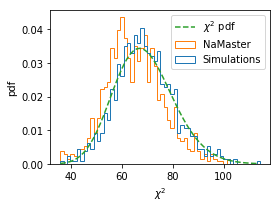

In [22]:
plot_chi2([chi2_sims, chi2_Th], ['Simulations', 'NaMaster'], 3*nells)

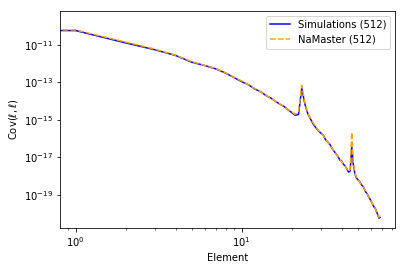

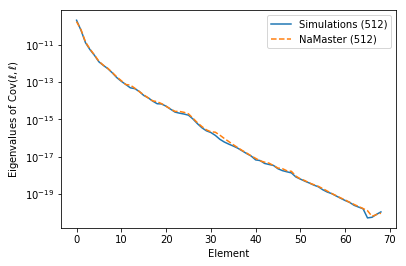

In [23]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

In [ ]:
plot_correlation_difference(np.arange(3*nells), CovSims, CovTh, labelTh='NaMaster');

# gc3 - wl1 512 all with new shear noise

## METACAL

In [79]:
#########################
# Prefix
simsdir = './sims_gc3_wl1_all_new_metacal/'
prefix = simsdir + 'run_gc3_wl1_all'
nside = 512
wltype = 'metacal'

#### Fiducial (Carlos)

cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_gc3wl1 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESgc3.npz')
cls_gc3gc3 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESwl1_DESwl1.npz')
cls_wl1wl1 = cls_fid_data['cls']

# Noise
nltt = np.loadtxt(prefix + '_nlth.txt', usecols=1)
nlee = np.loadtxt(prefix + '_nlth.txt', usecols=-4)
nlbb = np.loadtxt(prefix + '_nlth.txt', usecols=-1)


obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_{}_{}_new/'.format(wltype, nside)
cls_wl1wl1_obs = np.load(obs_path + 'cls_DESwl1_DESwl1.npz')


#################
#### David
dav_path = '/mnt/extraspace/damonge/S8z_data/derived_products/Cls_{}_c/'.format(wltype)



## IM3SHAPE (Comparing David's, mine with sims code and mine with general code)

In [4]:
#########################
# Prefix
simsdir = './sims_gc3_wl1_all_new/'
prefix = simsdir + 'run_gc3_wl1_all'
simsdir2 = './sims_gc3_wl1_all_new2/'
prefix2 = simsdir2 + 'run_gc3_wl1_all'
nside = 512
wltype = 'im3shape'

#### Fiducial (Carlos)

cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_gc3wl1 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESgc3.npz')
cls_gc3gc3 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESwl1_DESwl1.npz')
cls_wl1wl1 = cls_fid_data['cls']

# Noise
nltt = np.loadtxt(prefix + '_nlth.txt', usecols=1)
nlee = np.loadtxt(prefix + '_nlth.txt', usecols=-4)
nlbb = np.loadtxt(prefix + '_nlth.txt', usecols=-1)


obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_{}_{}_new/'.format(wltype, nside)
cls_wl1wl1_obs = np.load(obs_path + 'cls_DESwl1_DESwl1.npz')
cov_path = obs_path + 'cov_new_fiducial/'

#################
#### David
dav_path = '/mnt/extraspace/damonge/S8z_data/derived_products/Cls_{}_c/'.format(wltype)



### gc-gc

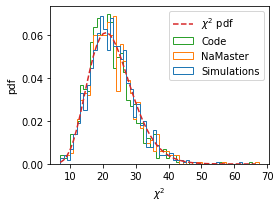

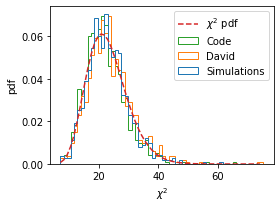

In [5]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]
CovTh2 = np.load(cov_path + 'cov_DESgc3_DESgc3_DESgc3_DESgc3.npz')['arr_0']
# CovTh2 = np.load(cov_path + 'cov_s0000_b3333.npz')['arr_0']
# CovTh = np.load(prefix2 + '_covTh.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]
CovThDav = np.load(dav_path + 'cov_gc3_gc3_x_gc3_gc3.npz')['cov'][:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)
plot_chi2([chi2_sims, chi2_ThDav, chi2_Th2], ['Simulations', 'David', 'Code'], ells.size)

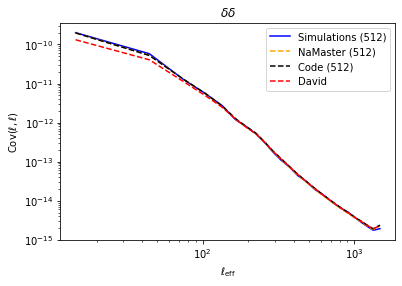

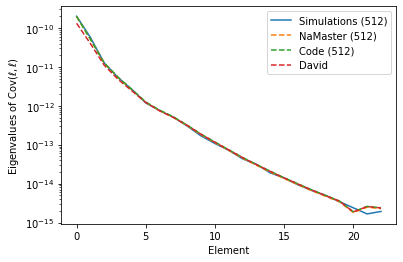

In [6]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='black', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', c='red', label='David')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \delta$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

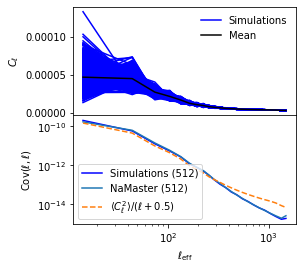

In [42]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

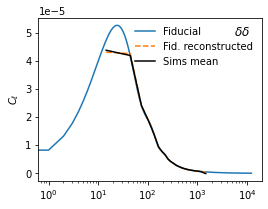

In [43]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_gc3gc3, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean - nltt, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \delta$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### gc-wl

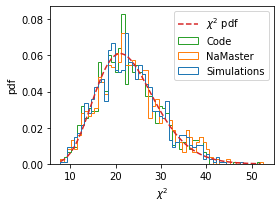

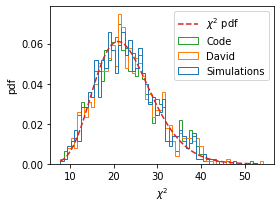

In [7]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=2)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]
CovTh2 = np.load(cov_path + 'cov_DESgc3_DESwl1_DESgc3_DESwl1.npz')['arr_0']
# CovTh2 = np.load(cov_path + 'cov_s0202_b3636.npz')['arr_0'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]
CovThDav = np.load(dav_path + 'cov_gc3_sh1_x_gc3_sh1.npz')['cov'][:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)
    
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)
plot_chi2([chi2_sims, chi2_ThDav, chi2_Th2], ['Simulations', 'David', 'Code'], ells.size)

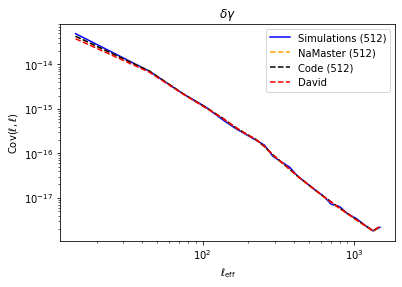

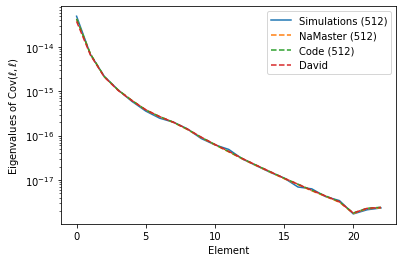

In [8]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='black', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', c='red', label='David')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

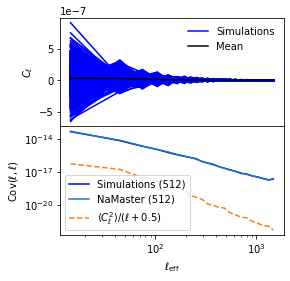

In [46]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

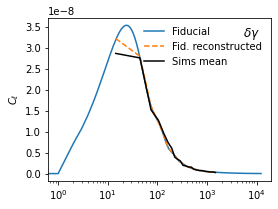

In [47]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_gc3wl1, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\delta \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### wl-wl

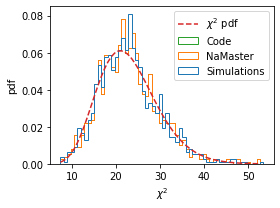

In [9]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]
CovTh2 = np.load(cov_path + 'cov_DESwl1_DESwl1_DESwl1_DESwl1.npz')['arr_0']
# CovTh2 = np.load(prefix2 + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]
CovThDav = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)
    
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)

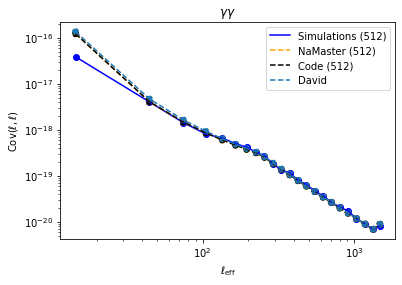

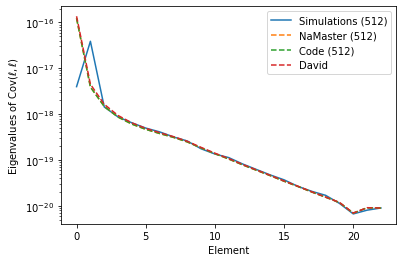

In [10]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='black', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')

plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovTh2), ls='--', c='black')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

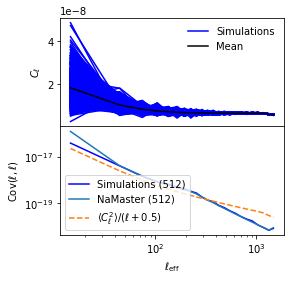

In [50]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

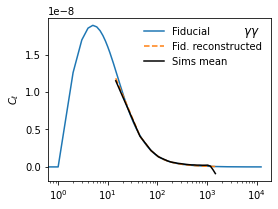

In [51]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean - nlee, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma \gamma$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### gcgc - gcwl - wlwl

In [11]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
nells = lbpw512.size
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
nsims = gc0gc0['cl00'].shape[0]
ells = gc0gc0['l']
cls_sims = np.zeros((nsims, nells * 3))
cls_sims[:, :nells] = gc0gc0['cl00'][:, 0, :]
cls_sims[:, nells : 2*nells] = gc0gc0['cl02'][:, 0, :]
cls_sims[:, 2*nells :] = gc0gc0['cl22'][:, 0, :]

cls_sims_mean = np.mean(cls_sims, axis=0)

CovSims = np.cov(cls_sims.T)

CovTh = np.zeros((nells * 3, nells * 3))
CovThDav = np.zeros((nells * 3, nells * 3))
CovTh2 = np.zeros((nells * 3, nells * 3))

Cload = np.load(prefix + '_covTh.npz')
# TT-TT
nelems1 = 1
nelems2 = 1
C = Cload['cw00_00'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, :nells] = C

C = np.load(dav_path + 'cov_gc3_gc3_x_gc3_gc3.npz')['cov'][:, 0, :, 0]
CovThDav[:nells, :nells] = C

C = np.load(cov_path + 'cov_DESgc3_DESgc3_DESgc3_DESgc3.npz')['arr_0']
CovTh2[:nells, :nells] = C
# TT-TE
nelems1 = 1
nelems2 = 2
C = Cload['cw00_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, nells:2*nells] = C
CovTh[nells:2*nells, :nells] = C.T

C = np.load(dav_path + 'cov_gc3_gc3_x_gc3_sh1.npz')['cov'][:, 0, :, 0]
CovThDav[:nells, nells:2*nells] = C
CovThDav[nells:2*nells, :nells] = C.T

C = np.load(cov_path + 'cov_DESgc3_DESgc3_DESgc3_DESwl1.npz')['arr_0']
CovTh2[:nells, nells:2*nells] = C
CovTh2[nells:2*nells, :nells] = C.T

# TT-EE
nelems1 = 1
nelems2 = 4
C = Cload['cw00_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, :nells] = C.T

C = np.load(dav_path + 'cov_gc3_gc3_x_sh1_sh1.npz')['cov'][:, 0, :, 0]
CovThDav[:nells, 2*nells:3*nells] = C
CovThDav[2*nells:3*nells, :nells] = C.T

C = np.load(cov_path + 'cov_DESgc3_DESgc3_DESwl1_DESwl1.npz')['arr_0']
CovTh2[:nells, 2*nells:3*nells] = C
CovTh2[2*nells:3*nells, :nells] = C.T

## TE-TE
nelems1 = 2
nelems2 = 2
C = Cload['cw02_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, nells:2*nells] = C

C = np.load(dav_path + 'cov_gc3_sh1_x_gc3_sh1.npz')['cov'][:, 0, :, 0]
CovThDav[nells:2*nells, nells:2*nells] = C

C = np.load(cov_path + 'cov_DESgc3_DESwl1_DESgc3_DESwl1.npz')['arr_0']
CovTh2[nells:2*nells, nells:2*nells] = C

## TE-EE
nelems1 = 2
nelems2 = 4
C = Cload['cw02_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, nells:2*nells] = C.T

C = np.load(dav_path + 'cov_gc3_sh1_x_sh1_sh1.npz')['cov'][:, 0, :, 0]
CovThDav[nells:2*nells, 2*nells:3*nells] = C
CovThDav[2*nells:3*nells, nells:2*nells] = C.T

C = np.load(cov_path + 'cov_DESgc3_DESwl1_DESwl1_DESwl1.npz')['arr_0']
CovTh2[nells:2*nells, 2*nells:3*nells] = C
CovTh2[2*nells:3*nells, nells:2*nells] = C.T
## EE-EE
nelems1 = 4
nelems2 = 4
C = Cload['cw22_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[2*nells:3*nells, 2*nells:3*nells] = C

C = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 0, :, 0]
CovThDav[2*nells:3*nells, 2*nells:3*nells] = C

C = np.load(cov_path + 'cov_DESwl1_DESwl1_DESwl1_DESwl1.npz')['arr_0']
CovTh2[2*nells:3*nells, 2*nells:3*nells] = C
###

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

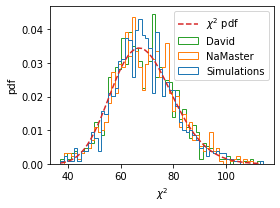

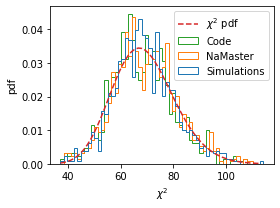

In [12]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], 3*nells)
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], 3*nells)

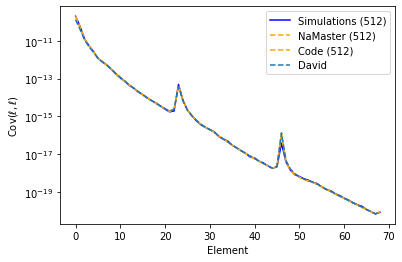

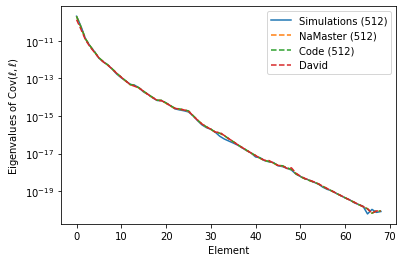

In [13]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(np.diag(CovTh2), ls='--', c='orange', label='Code (512)')
plt.plot(np.diag(CovThDav), ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')

plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

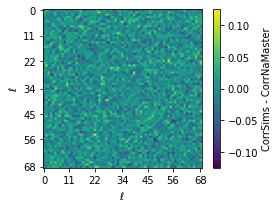

In [14]:
plot_correlation_difference(np.arange(3*nells), CovSims, CovTh, labelTh='NaMaster');

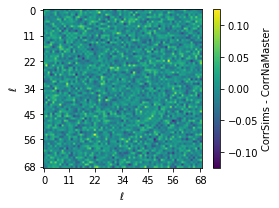

In [15]:
plot_correlation_difference(np.arange(3*nells), CovSims, CovTh2, labelTh='NaMaster');

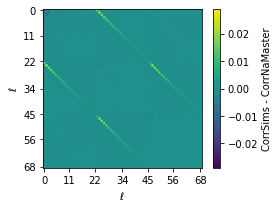

In [16]:
plot_correlation_difference(np.arange(3*nells), CovTh, CovThDav, labelTh='NaMaster');

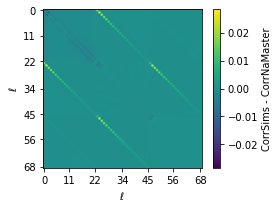

In [17]:
plot_correlation_difference(np.arange(3*nells), CovTh2, CovThDav, labelTh='NaMaster');

### wl-wl BB

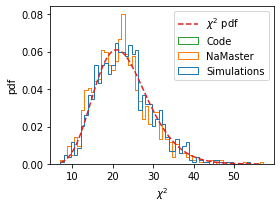

In [18]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=-1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 3, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 3, :, 3]
CovTh2 = np.load(cov_path + 'cov_s2222_b6666.npz')['arr_0'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 3, :, 3]
CovThDav = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 3, :, 3]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)
    
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)

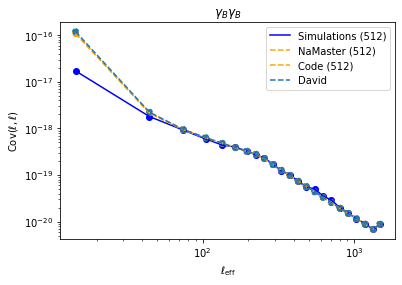

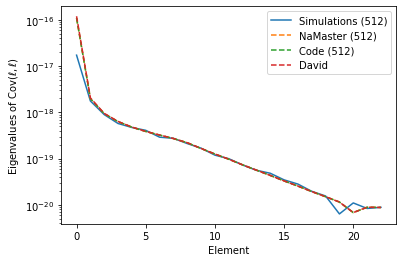

In [19]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='orange', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma_B \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

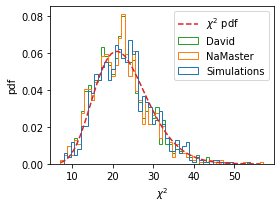

In [25]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

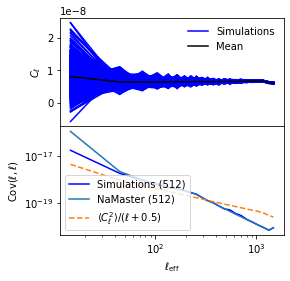

In [77]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

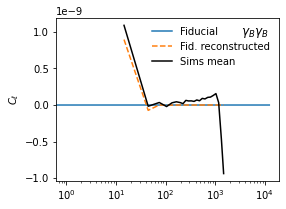

In [78]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean-nlbb, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### wl-wl EB

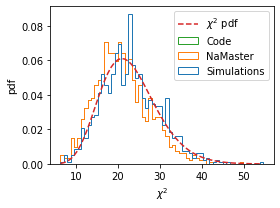

In [20]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=-3)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 1, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 1, :, 1]
CovTh2 = np.load(cov_path + 'cov_s2222_b6666.npz')['arr_0'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 1, :, 1]
CovThDav = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 1, :, 1]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)
    
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)

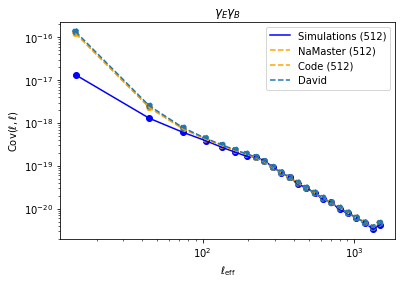

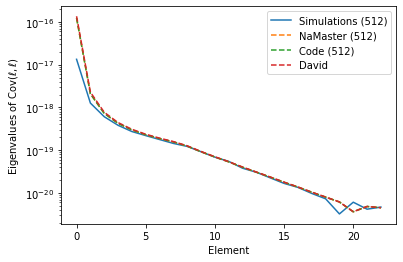

In [21]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='orange', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma_E \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

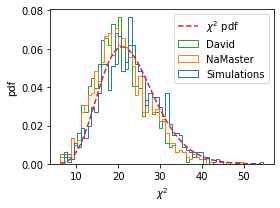

In [7]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

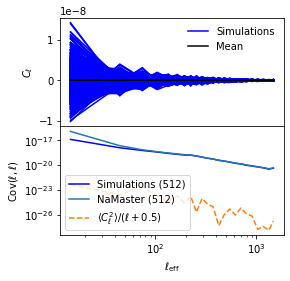

In [8]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

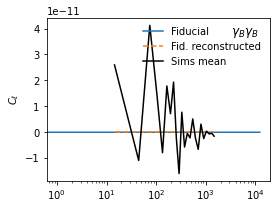

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean-nlbb*0, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### wl-wl TB

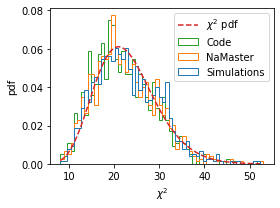

In [22]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=3)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 1, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 1, :, 1]
CovTh2 = np.load(cov_path + 'cov_s0202_b3636.npz')['arr_0'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 1, :, 1]
CovThDav = np.load(dav_path + 'cov_gc3_sh1_x_gc3_sh1.npz')['cov'][:, 1, :, 1]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovTh2 = np.linalg.inv(CovTh2)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_Th2 = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_Th2[i] = (delta).dot(iCovTh2).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)
    
plot_chi2([chi2_sims, chi2_Th, chi2_Th2], ['Simulations', 'NaMaster', 'Code'], ells.size)

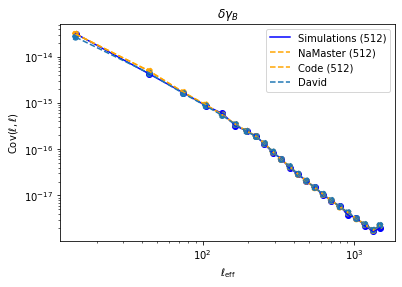

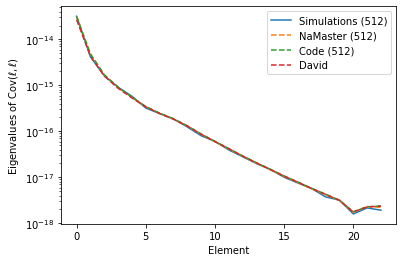

In [23]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovTh2), ls='--', c='orange', label='Code (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovTh2)[0], ls='--', label='Code (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

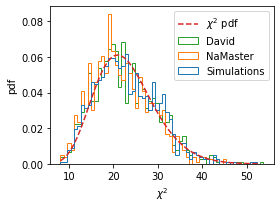

In [15]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

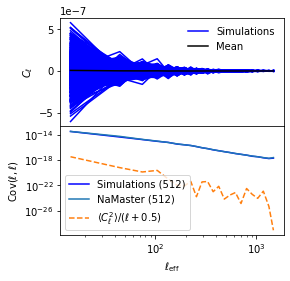

In [16]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

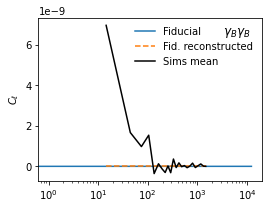

In [22]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

## Compare with old way (not coupled $C_\ell$)

In [4]:
#########################
# Prefix
simsdir = './sims_gc3_wl1_all_new/'
prefix = simsdir + 'run_gc3_wl1_all'
nside = 512
wltype = 'im3shape'

#### Fiducial (Carlos)

cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESwl1.npz')
ells_fid = cls_fid_data['ells']
cls_gc3wl1 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESgc3_DESgc3.npz')
cls_gc3gc3 = cls_fid_data['cls']
cls_fid_data = np.load('/mnt/extraspace/gravityls_3/S8z/Cls/fiducial/nobaryons/cls_DESwl1_DESwl1.npz')
cls_wl1wl1 = cls_fid_data['cls']

# Noise
nltt = np.loadtxt(prefix + '_nlth.txt', usecols=1)
nlee = np.loadtxt(prefix + '_nlth.txt', usecols=-4)
nlbb = np.loadtxt(prefix + '_nlth.txt', usecols=-1)


obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_{}_{}_new/'.format(wltype, nside)
cls_wl1wl1_obs = np.load(obs_path + 'cls_DESwl1_DESwl1.npz')


#################
#### David
dav_path = '/mnt/extraspace/damonge/S8z_data/derived_products/Cls_{}_c/'.format(wltype)



### gc-gc

In [23]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl00'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]
CovThDav = np.load(prefix + '_covThold.npz')['cw00_00'].reshape(lbpw512.size, 1, lbpw512.size, 1)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

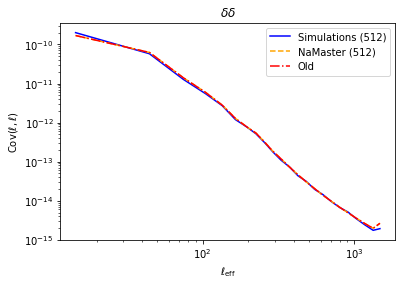

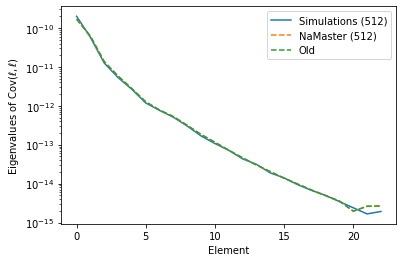

In [25]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='-.', c='red', label='Old')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \delta$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='Old')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### gc-wl

In [26]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=2)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]
CovThDav = np.load(prefix + '_covThold.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

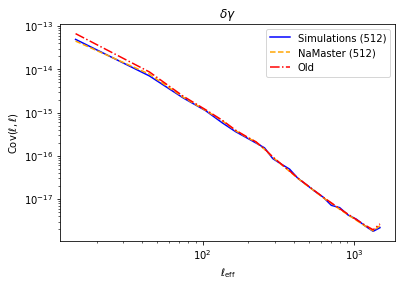

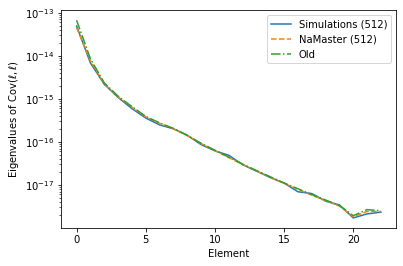

In [27]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='-.', c='red', label='Old')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='-.', label='Old')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### wl-wl

In [30]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 0, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]
CovThDav = np.load(prefix + '_covThold.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 0, :, 0]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

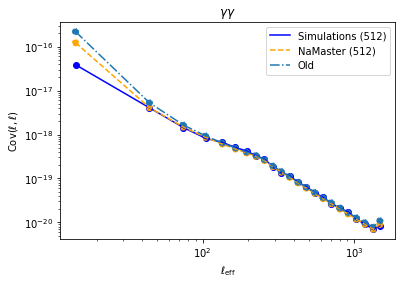

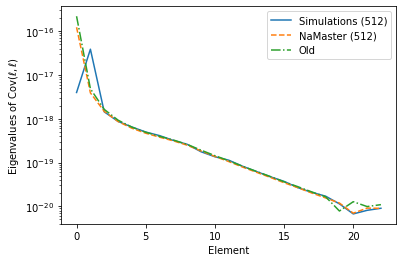

In [31]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='-.', label='Old')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='-.')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma \gamma$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='-.', label='Old')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

### gcgc - gcwl - wlwl

In [33]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
nells = lbpw512.size
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=4)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
nsims = gc0gc0['cl00'].shape[0]
ells = gc0gc0['l']
cls_sims = np.zeros((nsims, nells * 3))
cls_sims[:, :nells] = gc0gc0['cl00'][:, 0, :]
cls_sims[:, nells : 2*nells] = gc0gc0['cl02'][:, 0, :]
cls_sims[:, 2*nells :] = gc0gc0['cl22'][:, 0, :]

cls_sims_mean = np.mean(cls_sims, axis=0)

CovSims = np.cov(cls_sims.T)

CovTh = np.zeros((nells * 3, nells * 3))
CovThDav = np.zeros((nells * 3, nells * 3))

Cload = np.load(prefix + '_covTh.npz')
Cload2 = np.load(prefix + '_covThold.npz')

# TT-TT
nelems1 = 1
nelems2 = 1
C = Cload['cw00_00'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, :nells] = C

C = Cload2['cw00_00'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[:nells, :nells] = C
# TT-TE
nelems1 = 1
nelems2 = 2
C = Cload['cw00_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, nells:2*nells] = C
CovTh[nells:2*nells, :nells] = C.T

C = Cload2['cw00_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[:nells, nells:2*nells] = C
CovThDav[nells:2*nells, :nells] = C.T

# TT-EE
nelems1 = 1
nelems2 = 4
C = Cload['cw00_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[:nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, :nells] = C.T

C = Cload2['cw00_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[:nells, 2*nells:3*nells] = C
CovThDav[2*nells:3*nells, :nells] = C.T

## TE-TE
nelems1 = 2
nelems2 = 2
C = Cload['cw02_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, nells:2*nells] = C

C = Cload2['cw02_02'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[nells:2*nells, nells:2*nells] = C
## TE-EE
nelems1 = 2
nelems2 = 4
C = Cload['cw02_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[nells:2*nells, 2*nells:3*nells] = C
CovTh[2*nells:3*nells, nells:2*nells] = C.T

C = Cload2['cw02_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[nells:2*nells, 2*nells:3*nells] = C
CovThDav[2*nells:3*nells, nells:2*nells] = C.T
## EE-EE
nelems1 = 4
nelems2 = 4
C = Cload['cw22_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovTh[2*nells:3*nells, 2*nells:3*nells] = C

C = Cload2['cw22_22'].reshape(nells, nelems1, nells, nelems2)[:, 0, :, 0]
CovThDav[2*nells:3*nells, 2*nells:3*nells] = C
###

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

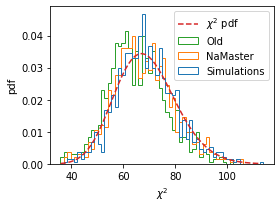

In [34]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'Old'], 3*nells)

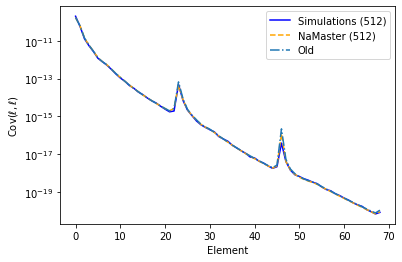

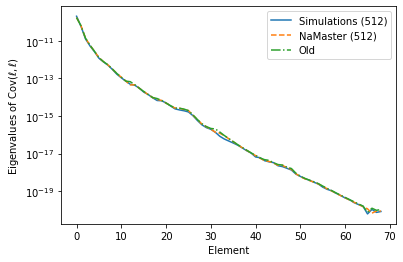

In [35]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(np.diag(CovThDav), ls='-.', label='Old')
plt.xlabel(r'Element')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='-.', label='Old')

plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

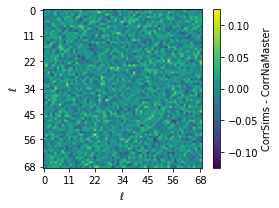

In [55]:
plot_correlation_difference(np.arange(3*nells), CovSims, CovTh, labelTh='NaMaster');

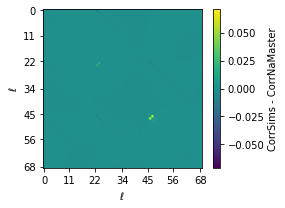

In [36]:
plot_correlation_difference(np.arange(3*nells), CovTh, CovThDav, labelTh='NaMaster');

### wl-wl BB

In [104]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=-1)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 3, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 3, :, 3]
CovThDav = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 3, :, 3]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

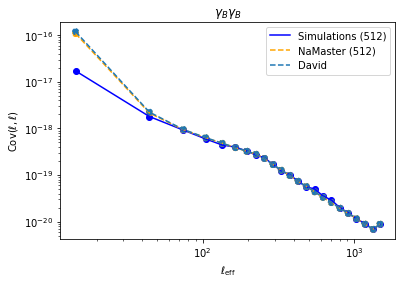

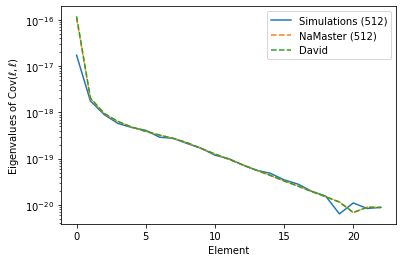

In [105]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma_B \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

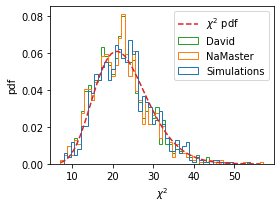

In [99]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

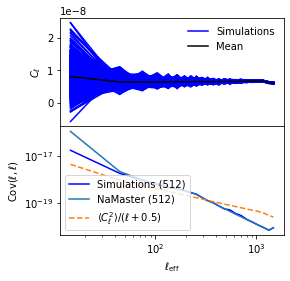

In [77]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

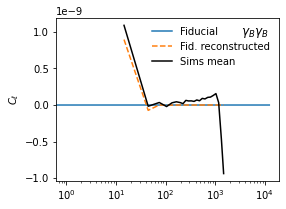

In [78]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean-nlbb, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### wl-wl EB

In [19]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=-3)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl22'][:, 1, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw22_22'].reshape(lbpw512.size, 4, lbpw512.size, 4)[:, 1, :, 1]
CovThDav = np.load(dav_path + 'cov_sh1_sh1_x_sh1_sh1.npz')['cov'][:, 1, :, 1]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

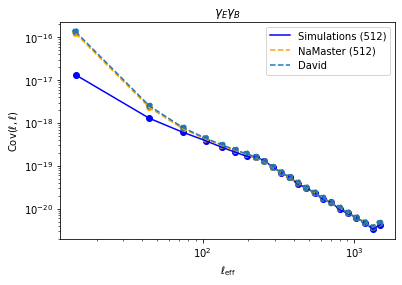

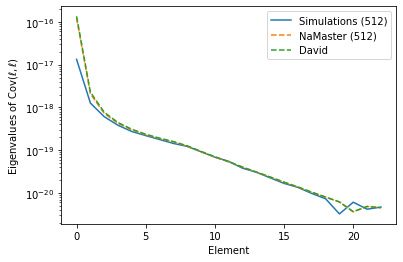

In [6]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\gamma_E \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

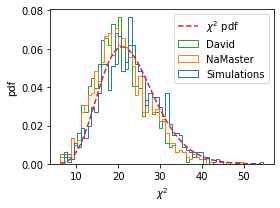

In [7]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

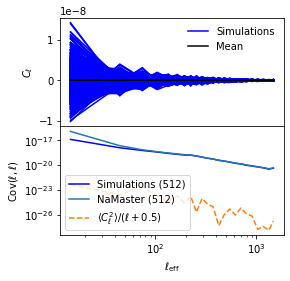

In [8]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

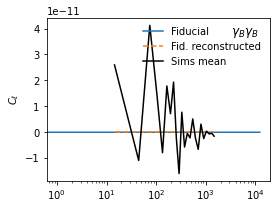

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean-nlbb*0, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

### wl-wl TB

In [21]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
cls_fid_reconst = np.loadtxt(prefix + '_clth.txt', usecols=3)

gc0gc0 = np.load(prefix + '_clsims_0001-1000.npz')
ells = gc0gc0['l']
cls_sims = gc0gc0['cl02'][:, 1, :]

nsims = cls_sims.shape[0]
cls_sims_mean = np.mean(cls_sims, axis=0)

# cls_sims = np.zeros((17, ells.size))
# for i in range(17):
#     cls_sims[i] = np.load(simsdir + 'run_debug_flat_cls__cl_%04d.npz' % (i+1))['cls']
CovSims = np.cov(cls_sims.T)

CovTh = np.load(prefix + '_covTh.npz')['cw02_02'].reshape(lbpw512.size, 2, lbpw512.size, 2)[:, 1, :, 1]
CovThDav = np.load(dav_path + 'cov_gc3_sh1_x_gc3_sh1.npz')['cov'][:, 1, :, 1]

iCovSims = np.linalg.inv(CovSims)
iCovTh = np.linalg.inv(CovTh)
iCovThDav = np.linalg.inv(CovThDav)

chi2_sims = np.ones(nsims) * (-1)
chi2_Th = np.ones(nsims) * (-1)
chi2_ThDav = np.ones(nsims) * (-1)

for i in range(nsims):
    delta = cls_sims[i] - cls_sims_mean
    chi2_sims[i] = (delta).dot(iCovSims).dot(delta)
    chi2_Th[i] = (delta).dot(iCovTh).dot(delta)
    chi2_ThDav[i] = (delta).dot(iCovThDav).dot(delta)

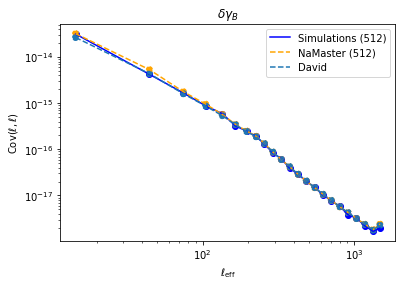

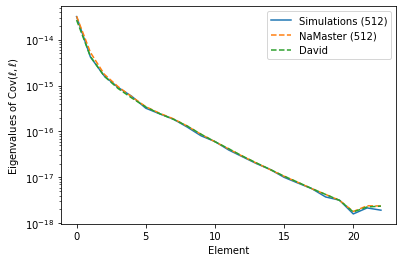

In [14]:
# Check diagonal elements of Covariances and their eigenvalues

plt.plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
plt.plot(ells, np.diag(CovTh), ls='--', c='orange', label='NaMaster (512)')
plt.plot(ells, np.diag(CovThDav), ls='--', label='David')
plt.scatter(ells, np.diag(CovSims), c='b')
plt.scatter(ells, np.diag(CovTh), ls='--', c='orange')
plt.scatter(ells, np.diag(CovThDav), ls='--')
plt.xlabel(r'$\ell_{\rm eff}$')
plt.ylabel(r'Cov$(\ell, \ell)$')
plt.yscale('log')
plt.xscale('log')
plt.title(r'$\delta \gamma_B$')
plt.legend(loc=0)
plt.show()

# # Check eigenvalues
plt.plot(np.linalg.eig(CovSims)[0], label='Simulations (512)')
plt.plot(np.linalg.eig(CovTh)[0], ls='--', label='NaMaster (512)')
plt.plot(np.linalg.eig(CovThDav)[0], ls='--', label='David')
plt.xlabel(r'Element')
plt.ylabel(r'Eigenvalues of Cov$(\ell, \ell)$')
plt.yscale('log')
plt.legend(loc=0)
plt.show()

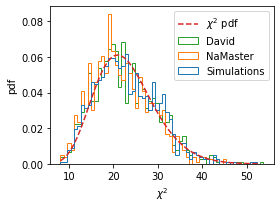

In [15]:
plot_chi2([chi2_sims, chi2_Th, chi2_ThDav], ['Simulations', 'NaMaster', 'David'], ells.size)

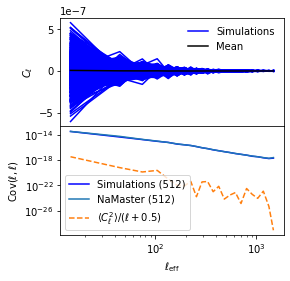

In [16]:
f, ax = plt.subplots(2, 1, figsize=(4,4), gridspec_kw={'hspace': 0}, sharex=True)
for i in range(cls_sims.shape[0]):
    ax[0].plot(ells, cls_sims[i], c='b', label='Simulations' if i==0 else '')
ax[0].plot(ells, cls_sims_mean, c='k', label='Mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].legend(loc=0, frameon=False)

ax[1].plot(ells, np.diag(CovSims), c='b', label='Simulations (512)')
ax[1].plot(ells, np.diag(CovTh), label='NaMaster (512)')
# ax[1].plot(lbpw2048, np.mean((cls_sims-cls_sims_mean)**2, axis=0), ls='--', label='Handmade')
ax[1].plot(ells, cls_sims_mean**2/(ells +0.5), ls='--', label=r'$\langle C_\ell^2\rangle / (\ell + 0.5)$')

ax[1].set_xlabel(r'$\ell_{\rm eff}$')
ax[1].set_ylabel(r'Cov$(\ell, \ell)$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')
plt.show()

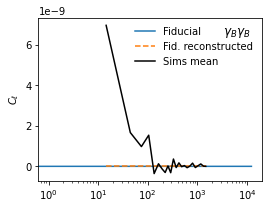

In [22]:
f, ax = plt.subplots(1, 1, figsize=(4,3), gridspec_kw={'hspace': 0}, sharex=True)
ax = [ax]
ax[0].plot(ells_fid, cls_wl1wl1*0, label='Fiducial')
ax[0].plot(ells, cls_fid_reconst, ls='--', label='Fid. reconstructed')
ax[0].plot(ells, cls_sims_mean, c='k', label='Sims mean')
ax[0].set_ylabel(r'$C_\ell$')
# ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].text(0.95, 0.95, r'$\gamma_{B} \gamma_{B}$', horizontalalignment='right',
      verticalalignment='top', transform=ax[0].transAxes, fontsize=12)
ax[0].legend(loc=0, frameon=False)
plt.show()

# Masks

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/projaxes.py:1197: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/projaxes.py:1156: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


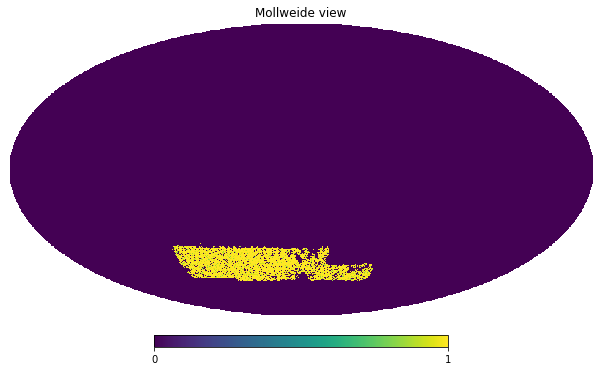

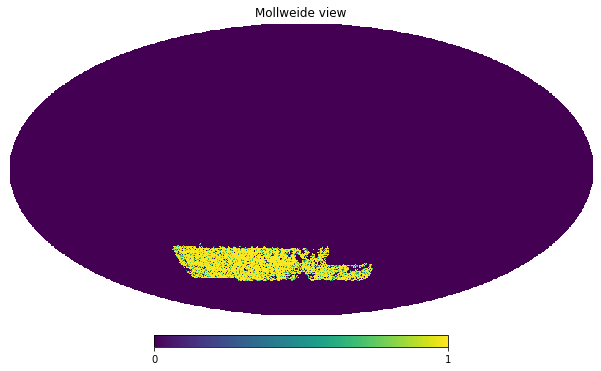

In [4]:
mask4096 = hp.read_map('/mnt/extraspace/damonge/S8z_data/derived_products/des_clustering/mask_ns4096.fits')
mask2048 = hp.read_map('/mnt/extraspace/damonge/S8z_data/derived_products/des_clustering/mask_ns2048.fits')
hp.mollview(mask4096)
hp.mollview(mask2048)

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0
1.0
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0
3159.87109375


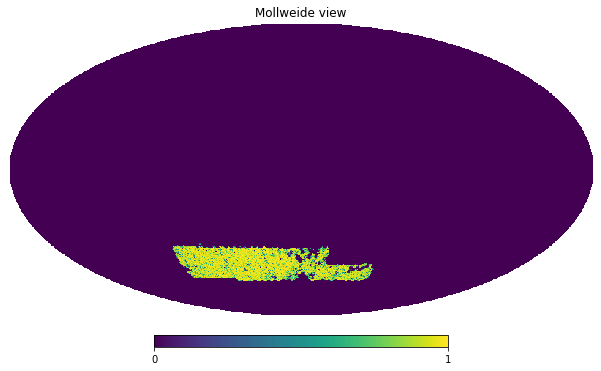

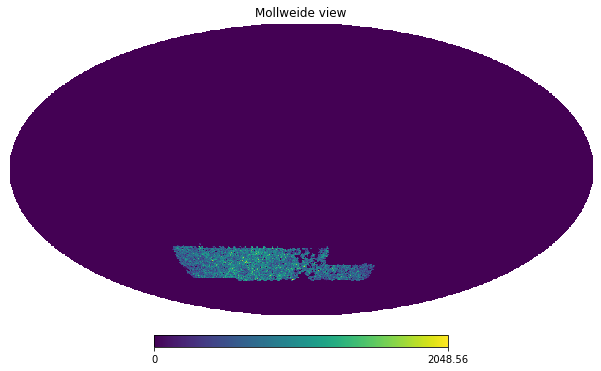

In [71]:
mask512gc = hp.read_map('/mnt/extraspace/damonge/S8z_data/derived_products/des_clustering/mask_ns512.fits')
hp.mollview(mask512gc)
print(np.min(mask512gc))
print(np.max(mask512gc))
mask512wl1 = hp.read_map('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/map_im3shape_bin1_counts_w_ns512.fits')
hp.mollview(mask512wl1)
print(np.min(mask512wl1))
print(np.max(mask512wl1))

In [73]:
we1 = hp.read_map('/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/map_im3shape_bin0_counts_e1_ns512.fits')
print(np.min(we1))
print(np.max(we1))

print(np.min(we1[mask512wl1 > 0]))
print(np.max(we1[mask512wl1 > 0]))

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
-142.765029907
177.238143921
-142.765029907
177.238143921


In [77]:
we1[mask512wl1==0].max()

14.726399421691895

# PSFs (512)

## PSF - $e_i$ (IM3SHAPE)

In [5]:
wltype = 'im3shape'
nside = 512

obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_{}_{}_new/'.format(wltype, nside)

cls_psf_file = np.load(obs_path + 'cls_psfi-ei.npz')
lbpw = cls_psf_file['l']
cls_psf = cls_psf_file['cls']

CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov']

labels = ['EE', 'EB', 'BE', 'BB']

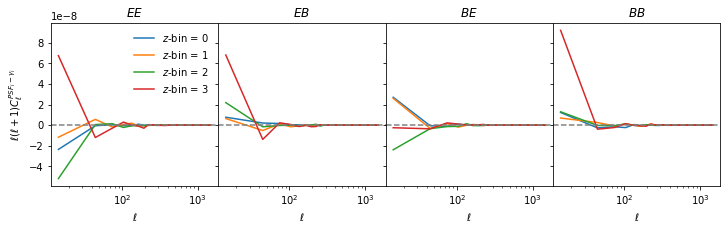

In [28]:
f, ax = plt.subplots(1, 4, figsize=(12, 3), gridspec_kw={'hspace': 0, 'wspace':0},
                     sharex=True, sharey=True)
for ibin, cls in enumerate(cls_psf):
    cls = cls.reshape((4, -1))
    for j, clsj in enumerate(cls):
        ax[j].semilogx(lbpw, clsj, label=r'$z$-bin = {}'.format(ibin))

for i, label in enumerate(labels):
    ax[i].set_title(r'${}$'.format(label))
    ax[i].set_xlabel(r'$\ell$')
    ax[i].axhline(0, c='gray', ls='--')
    
ax[0].set_ylabel(r'$\ell(\ell + 1) C_\ell^{PSF_i-\gamma_i}$')
ax[0].legend(loc=0, frameon=False)
plt.show()
plt.close()

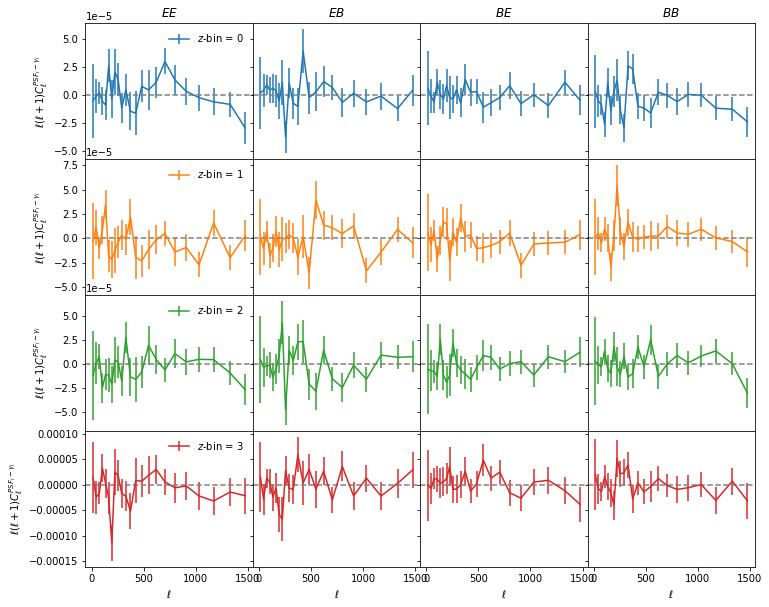

In [26]:
f, ax = plt.subplots(4, 4, figsize=(12, 10), gridspec_kw={'hspace': 0, 'wspace':0},
                     sharex=True, sharey='row')
for ibin, cls in enumerate(cls_psf):
    cls = cls.reshape((4, -1))
    for j, clsj in enumerate(cls):
        yerr = np.sqrt(np.diag(CovTh[ibin][:, j, :, j]))
        ax[ibin, j].errorbar(lbpw, lbpw*(lbpw+1)*clsj, yerr=lbpw*(lbpw+1)*yerr, c=DCOLORS[ibin], label=r'$z$-bin = {}'.format(ibin))
        ax[ibin, j].axhline(0, c='gray', ls='--')

for i, label in enumerate(labels):
    ax[0, i].set_title(r'${}$'.format(label))
    ax[-1, i].set_xlabel(r'$\ell$')
    ax[i, 0].set_ylabel(r'$\ell(\ell + 1) C_\ell^{PSF_i-\gamma_i}$')
    ax[i,0].legend(loc=0, frameon=False)
plt.show()
plt.close()

## $\chi^2$

In [23]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw512
ibin = 1

CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov'][ibin][:, 0, :, 0]

iCovTh = np.linalg.inv(CovTh)

chi2 = cls_psf[ibin][0, 0].dot(iCovTh).dot(cls_psf[ibin][0, 0])
print('chi2 = ', chi2)
print('chi2/dof = ', chi2/ells.size)

chi2 =  24.9537649679
chi2/dof =  1.08494630295


In [31]:
for ibin in range(4):
    print('z-bin = ', ibin)
    for j, label in enumerate(labels):
        cls = cls_psf[ibin].reshape((4, -1))[j]
        CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov'][ibin][:, j, :, j]
        iCovTh = np.linalg.inv(CovTh)

        chi2 = cls.dot(iCovTh).dot(cls)
        print('Mode ', label)
        print('chi2 = ', chi2)
        print('chi2/dof = ', chi2/(ells.size))
        print()

z-bin =  0
Mode  EE
chi2 =  23.0413059456
chi2/dof =  1.00179591068

Mode  EB
chi2 =  17.83636022
chi2/dof =  0.775493922611

Mode  BE
chi2 =  7.42323202072
chi2/dof =  0.322749218292

Mode  BB
chi2 =  34.1961536479
chi2/dof =  1.48678928904

z-bin =  1
Mode  EE
chi2 =  24.9537649679
chi2/dof =  1.08494630295

Mode  EB
chi2 =  27.2403953614
chi2/dof =  1.18436501571

Mode  BE
chi2 =  15.9774928987
chi2/dof =  0.694673604289

Mode  BB
chi2 =  19.0163693652
chi2/dof =  0.826798668052

z-bin =  2
Mode  EE
chi2 =  16.1159975768
chi2/dof =  0.700695546818

Mode  EB
chi2 =  28.2646656609
chi2/dof =  1.228898507

Mode  BE
chi2 =  14.8890803915
chi2/dof =  0.647351321371

Mode  BB
chi2 =  16.8820356166
chi2/dof =  0.734001548549

z-bin =  3
Mode  EE
chi2 =  23.940743097
chi2/dof =  1.04090187378

Mode  EB
chi2 =  21.1415626988
chi2/dof =  0.919198378211

Mode  BE
chi2 =  10.510906949
chi2/dof =  0.456995954304

Mode  BB
chi2 =  14.1213134645
chi2/dof =  0.613970150632



In [33]:
Cov_ar = np.load(obs_path + 'cov_psfi-ei.npz')['cov']
for ibin in range(4):
    print('z-bin = ', ibin)
    cls = cls_psf[ibin].reshape(-1)
    CovTh = Cov_ar[ibin].reshape(4*ells.size, 4*ells.size)
    iCovTh = np.linalg.inv(CovTh)

    chi2 = cls.dot(iCovTh).dot(cls)
    print('chi2 = ', chi2)
    print('chi2/dof = ', chi2/(ells.size))
    print()

z-bin =  0
chi2 =  525188.806472
chi2/dof =  22834.2959336

z-bin =  1
chi2 =  183720.409127
chi2/dof =  7987.84387508

z-bin =  2
chi2 =  400844.520342
chi2/dof =  17428.0226236

z-bin =  3
chi2 =  4508365.48535
chi2/dof =  196015.890667



In [27]:
CovTh.T == CovTh

array([[ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False,  True]], dtype=bool)

## Mollview

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


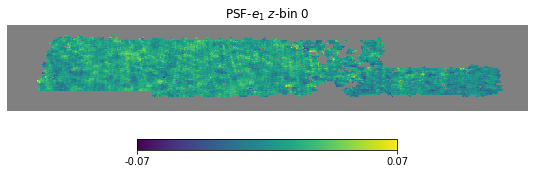

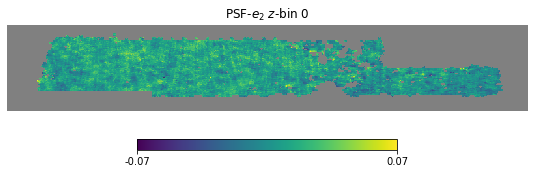

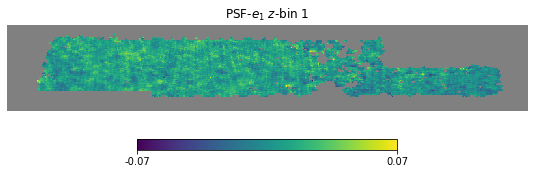

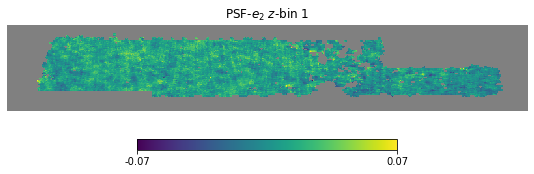

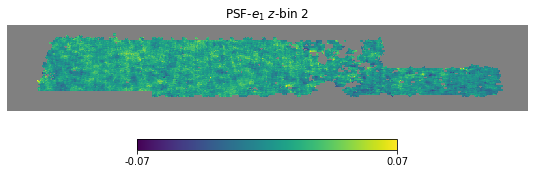

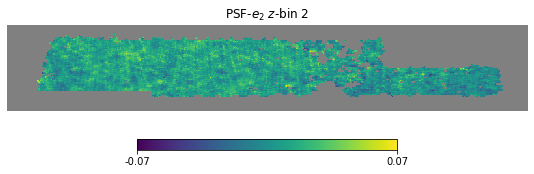

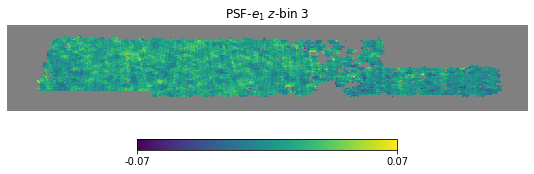

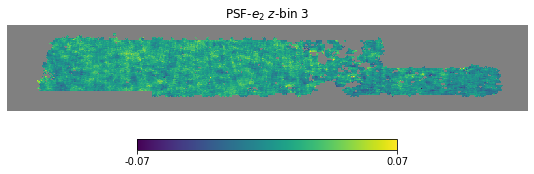

In [6]:
data_path = '/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/'
wltype = 'im3shape'
ibin = 0
for ibin in range(4):
    psfE1 = hp.read_map(data_path + 'map_{}_bin{}_wpsfe1_ns512.fits'.format(wltype, ibin), verbose=False)
    psfE2 = hp.read_map(data_path + 'map_{}_bin{}_wpsfe1_ns512.fits'.format(wltype, ibin), verbose=False)
    mask = hp.read_map(data_path + 'map_{}_bin{}_w_ns512.fits'.format(wltype, ibin), verbose=False)

    psfE1[mask <= 0] = hp.UNSEEN
    psfE1[mask > 0] /= mask[mask > 0]
    psfE2[mask <= 0] = hp.UNSEEN
    psfE2[mask > 0] /= mask[mask > 0]

#     hp.mollview(psfE1, title='PSF-${{e_1}}$ $z$-bin {}'.format(ibin))
#     hp.mollview(psfE2, title='PSF-${{e_2}}$ $z$-bin {}'.format(ibin))
    hp.cartview(psfE1, lonra=[-70, 110], latra=[-65, -35], min=-0.07, max=0.07,
                title='PSF-${{e_1}}$ $z$-bin {}'.format(ibin))
    hp.cartview(psfE2, lonra=[-70, 110], latra=[-65, -35],  min=-0.07, max=0.07,
                title='PSF-${{e_2}}$ $z$-bin {}'.format(ibin))

# PSFs (4096)

## PSF - $e_i$ (METACAL)

In [21]:
wltype = 'metacal'
nside = 4096

obs_path = '/mnt/extraspace/gravityls_3/S8z/Cls/all_together_{}_new/'.format(wltype, nside)

cls_psf_file = np.load(obs_path + 'cls_psfi-ei.npz')
lbpw = cls_psf_file['l']
cls_psf = cls_psf_file['cls']

CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov']

labels = ['EE', 'EB', 'BE', 'BB']

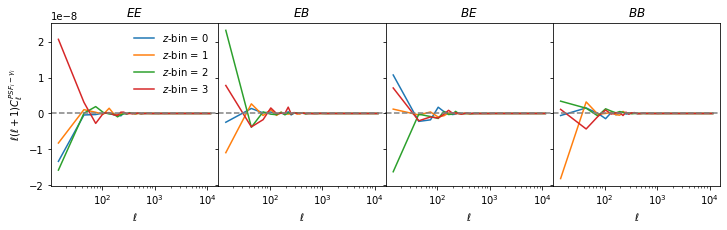

In [7]:
f, ax = plt.subplots(1, 4, figsize=(12, 3), gridspec_kw={'hspace': 0, 'wspace':0},
                     sharex=True, sharey=True)
for ibin, cls in enumerate(cls_psf):
    cls = cls.reshape((4, -1))
    for j, clsj in enumerate(cls):
        ax[j].semilogx(lbpw, clsj, label=r'$z$-bin = {}'.format(ibin))

for i, label in enumerate(labels):
    ax[i].set_title(r'${}$'.format(label))
    ax[i].set_xlabel(r'$\ell$')
    ax[i].axhline(0, c='gray', ls='--')
    
ax[0].set_ylabel(r'$\ell(\ell + 1) C_\ell^{PSF_i-\gamma_i}$')
ax[0].legend(loc=0, frameon=False)
plt.show()
plt.close()

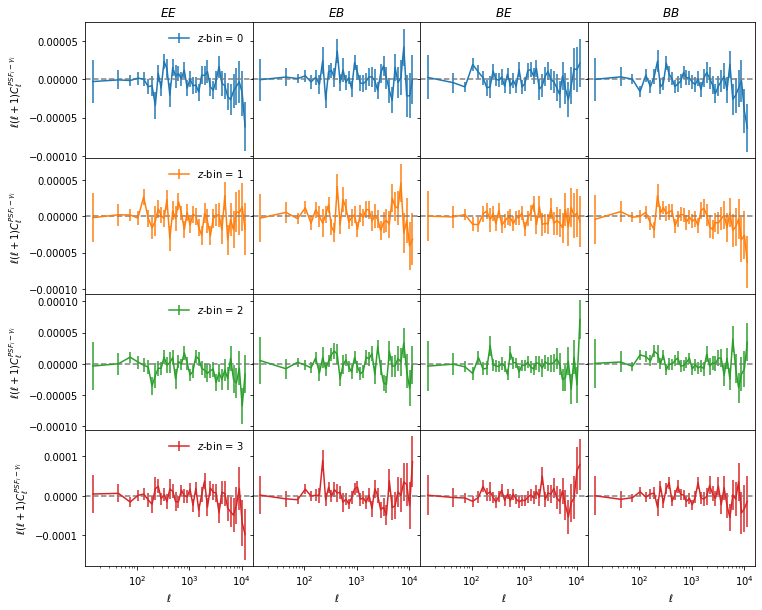

In [9]:
f, ax = plt.subplots(4, 4, figsize=(12, 10), gridspec_kw={'hspace': 0, 'wspace':0},
                     sharex=True, sharey='row')
for ibin, cls in enumerate(cls_psf):
    cls = cls.reshape((4, -1))
    for j, clsj in enumerate(cls):
        yerr = np.sqrt(np.diag(CovTh[ibin][:, j, :, j]))
        ax[ibin, j].errorbar(lbpw, lbpw*(lbpw+1)*clsj, yerr=lbpw*(lbpw+1)*yerr, c=DCOLORS[ibin], label=r'$z$-bin = {}'.format(ibin))
        ax[ibin, j].axhline(0, c='gray', ls='--')

for i, label in enumerate(labels):
    ax[0, i].set_title(r'${}$'.format(label))
    ax[-1, i].set_xlabel(r'$\ell$')
    ax[i, 0].set_ylabel(r'$\ell(\ell + 1) C_\ell^{PSF_i-\gamma_i}$')
    ax[i,0].legend(loc=0, frameon=False)
    ax[-1, i].set_xscale('log')
plt.show()
plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


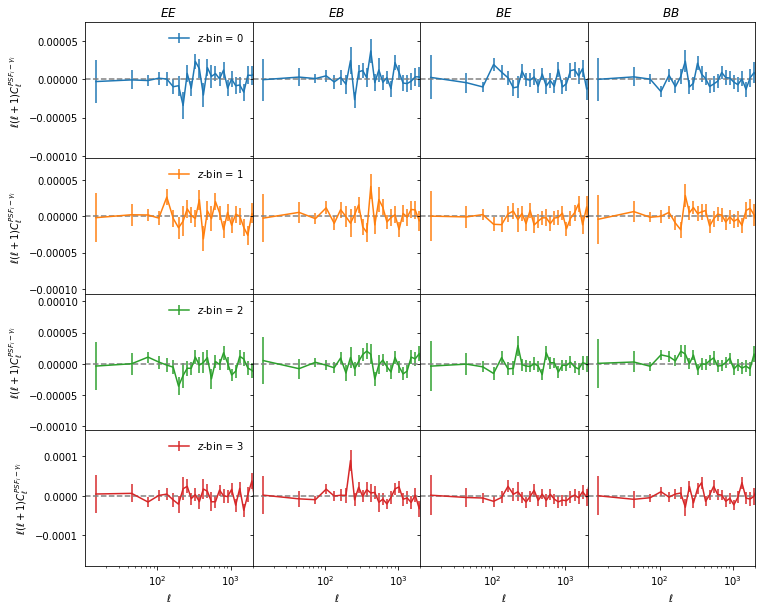

In [22]:
f, ax = plt.subplots(4, 4, figsize=(12, 10), gridspec_kw={'hspace': 0, 'wspace':0},
                     sharex=True, sharey='row')
for ibin, cls in enumerate(cls_psf):
    cls = cls.reshape((4, -1))
    for j, clsj in enumerate(cls):
        yerr = np.sqrt(np.diag(CovTh[ibin][:, j, :, j]))
        ax[ibin, j].errorbar(lbpw, lbpw*(lbpw+1)*clsj, yerr=lbpw*(lbpw+1)*yerr, c=DCOLORS[ibin], label=r'$z$-bin = {}'.format(ibin))
        ax[ibin, j].axhline(0, c='gray', ls='--')

for i, label in enumerate(labels):
    ax[0, i].set_title(r'${}$'.format(label))
    ax[-1, i].set_xlabel(r'$\ell$')
    ax[i, 0].set_ylabel(r'$\ell(\ell + 1) C_\ell^{PSF_i-\gamma_i}$')
    ax[i,0].legend(loc=0, frameon=False)
    ax[-1, i].set_xscale('log')
    ax[-1, i].set_xlim([0, 2e3])

plt.show()
plt.close()

## $\chi^2$

In [10]:
# Load Cls, covariances, compute inverses and chi2

ells = lbpw4096
ibin = 1

CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov'][ibin][:, 0, :, 0]

iCovTh = np.linalg.inv(CovTh)

chi2 = cls_psf[ibin][0, 0].dot(iCovTh).dot(cls_psf[ibin][0, 0])
print('chi2 = ', chi2)
print('chi2/dof = ', chi2/ells.size)

chi2 =  39.7282576982
chi2/dof =  1.01867327431


In [19]:
imax = np.where(~(ells < 2000))[0][0]
for ibin in range(4):
    print('z-bin = ', ibin)
    for j, label in enumerate(labels):
        cls = cls_psf[ibin][:, :, :imax].reshape((4, -1))[j]
        CovTh = np.load(obs_path + 'cov_psfi-ei.npz')['cov'][ibin][:imax, j, :imax, j]
        iCovTh = np.linalg.inv(CovTh)

        chi2 = cls.dot(iCovTh).dot(cls)
        print('Mode ', label)
        print('chi2 = ', chi2)
        print('chi2/dof = ', chi2/(ells[:imax].size))
        print()

z-bin =  0
Mode  EE
chi2 =  24.1992679393
chi2/dof =  0.96797071757

Mode  EB
chi2 =  25.5437946713
chi2/dof =  1.02175178685

Mode  BE
chi2 =  25.974856552
chi2/dof =  1.03899426208

Mode  BB
chi2 =  22.9220872781
chi2/dof =  0.916883491123

z-bin =  1
Mode  EE
chi2 =  27.9692673321
chi2/dof =  1.11877069329

Mode  EB
chi2 =  25.7117332063
chi2/dof =  1.02846932825

Mode  BE
chi2 =  15.6293969591
chi2/dof =  0.625175878363

Mode  BB
chi2 =  19.6500062938
chi2/dof =  0.786000251753

z-bin =  2
Mode  EE
chi2 =  25.0031627571
chi2/dof =  1.00012651028

Mode  EB
chi2 =  28.2425334933
chi2/dof =  1.12970133973

Mode  BE
chi2 =  18.1214529775
chi2/dof =  0.724858119101

Mode  BB
chi2 =  28.1673016501
chi2/dof =  1.126692066

z-bin =  3
Mode  EE
chi2 =  23.137333721
chi2/dof =  0.92549334884

Mode  EB
chi2 =  31.3154565126
chi2/dof =  1.2526182605

Mode  BE
chi2 =  11.9462137726
chi2/dof =  0.477848550902

Mode  BB
chi2 =  29.5381079756
chi2/dof =  1.18152431903



In [12]:
Cov_ar = np.load(obs_path + 'cov_psfi-ei.npz')['cov']
for ibin in range(4):
    print('z-bin = ', ibin)
    cls = cls_psf[ibin].reshape(-1)
    CovTh = Cov_ar[ibin].reshape(4*ells.size, 4*ells.size)
    iCovTh = np.linalg.inv(CovTh)

    chi2 = cls.dot(iCovTh).dot(cls)
    print('chi2 = ', chi2)
    print('chi2/dof = ', chi2/(ells.size))
    print()

z-bin =  0
chi2 =  7627739.74129
chi2/dof =  195583.07029

z-bin =  1
chi2 =  252536980.158
chi2/dof =  6475307.18355

z-bin =  2
chi2 =  20019401.9526
chi2/dof =  513317.998785

z-bin =  3
chi2 =  7783357.95408
chi2/dof =  199573.280874



In [13]:
CovTh.T == CovTh

array([[ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True, False,  True]], dtype=bool)

## Mollview

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


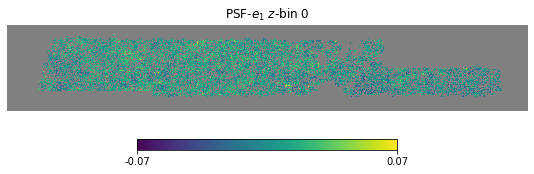

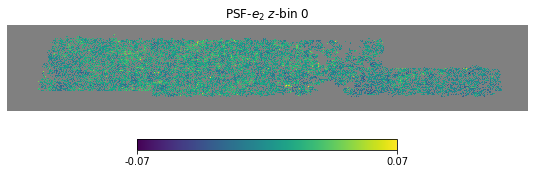

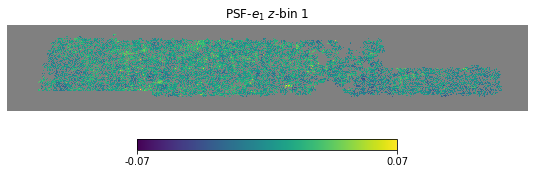

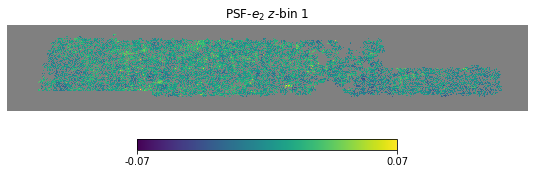

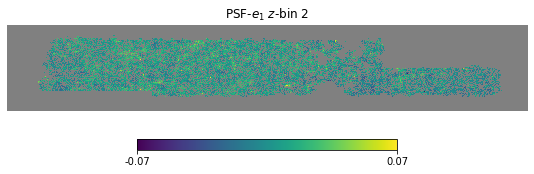

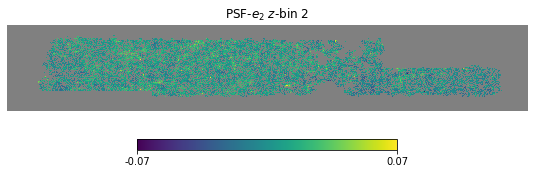

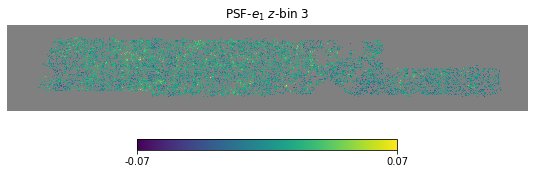

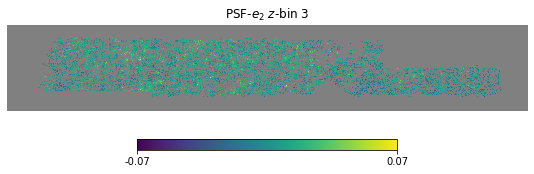

In [23]:
data_path = '/mnt/extraspace/damonge/S8z_data/derived_products/des_shear/'
wltype = 'metacal'
nside=4096
ibin = 0
for ibin in range(4):
    psfE1 = hp.read_map(data_path + 'map_{}_bin{}_wpsfe1_ns{}.fits'.format(wltype, ibin, nside), verbose=False)
    psfE2 = hp.read_map(data_path + 'map_{}_bin{}_wpsfe1_ns{}.fits'.format(wltype, ibin, nside), verbose=False)
    mask = hp.read_map(data_path + 'map_{}_bin{}_w_ns{}.fits'.format(wltype, ibin, nside), verbose=False)

    psfE1[mask <= 0] = hp.UNSEEN
    psfE1[mask > 0] /= mask[mask > 0]
    psfE2[mask <= 0] = hp.UNSEEN
    psfE2[mask > 0] /= mask[mask > 0]

#     hp.mollview(psfE1, title='PSF-${{e_1}}$ $z$-bin {}'.format(ibin))
#     hp.mollview(psfE2, title='PSF-${{e_2}}$ $z$-bin {}'.format(ibin))
    hp.cartview(psfE1, lonra=[-70, 110], latra=[-65, -35], min=-0.07, max=0.07,
                title='PSF-${{e_1}}$ $z$-bin {}'.format(ibin))
    hp.cartview(psfE2, lonra=[-70, 110], latra=[-65, -35],  min=-0.07, max=0.07,
                title='PSF-${{e_2}}$ $z$-bin {}'.format(ibin))